# Phylogenetic Distance Calculation from RhizCG 2013

Test hypotheses on phylogenetic vs functional control of microbial community
Use phylogeny created from rbcL and matK in phylogenerator 20160209_phylogeny.tre. 
Test hypothesis on overall dataset, then subgroups

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(foreach)
library(lsmeans)
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(phyloseq)
library(doParallel)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: estimability

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: survival

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: For

In [3]:
%%R
# Initialize corMLPE 
source('/home/bryan/corMLPE/corMLPE.R')

In [4]:
%%R
workDir = '/home/bryan/RhizCG/PhyDist/'


# Set up tables and tree 

In [5]:
%%R
setwd(workDir)
# read phylogenetic distance, expanded with 0.0002 between maize lines
phy_expand = read.csv(file = "phyDist_expanded.csv", header = TRUE)
colnames(phy_expand)[12] = "75-062"

In [6]:
%%R
phy_expand

         FAGES   AMAPO   HELAN   ABUTH   GLYMA   SORBI     B73   ECHCG   SETFA
FAGES  0.00000 0.23210 0.25302 0.27096 0.35879 0.43476 0.43787 0.43985 0.43592
AMAPO  0.23210 0.00000 0.20952 0.22746 0.31529 0.39126 0.39437 0.39635 0.39242
HELAN  0.25302 0.20952 0.00000 0.19116 0.27899 0.35496 0.35807 0.36005 0.35612
ABUTH  0.27096 0.22746 0.19116 0.00000 0.24183 0.35370 0.35681 0.35879 0.35486
GLYMA  0.35879 0.31529 0.27899 0.24183 0.00000 0.44153 0.44464 0.44662 0.44269
SORBI  0.43476 0.39126 0.35496 0.35370 0.44153 0.00000 0.01153 0.03193 0.02800
B73    0.43787 0.39437 0.35807 0.35681 0.44464 0.01153 0.00000 0.03504 0.03111
ECHCG  0.43985 0.39635 0.36005 0.35879 0.44662 0.03193 0.03504 0.00000 0.02517
SETFA  0.43592 0.39242 0.35612 0.35486 0.44269 0.02800 0.03111 0.02517 0.00000
ERATE  0.44622 0.40272 0.36642 0.36516 0.45299 0.04656 0.04967 0.05165 0.04772
ELCOR  0.44745 0.40395 0.36765 0.36639 0.45422 0.04779 0.05090 0.05288 0.04895
75-062 0.43787 0.39437 0.35807 0.35681 0.44464 0.011

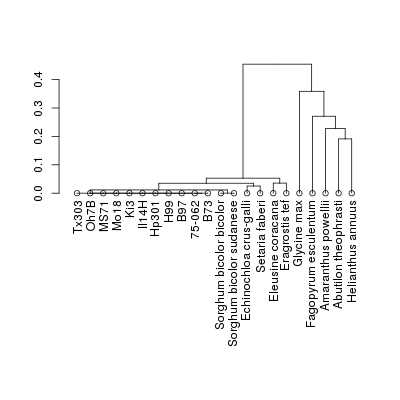

In [7]:
%%R -w 400 -h 400

# simplify, re-order matrix so that plants appear in same order as they are in the legend key.  then 
Mat = phy_expand
colnames(Mat) = c("Fagopyrum esculentum", "Amaranthus powellii", "Helianthus annuus", "Abutilon theophrasti",
                 "Glycine max", "Sorghum bicolor bicolor", "B73", "Echinochloa crus-galli", 
                  "Setaria faberi",  "Eragrostis tef","Eleusine coracana", "75-062", "Oh7B", "MS71", "B97",
                  "H99", "Il14H", "Ki3", "Tx303","Hp301", "Mo18", "Sorghum bicolor sudanese")
rownames(Mat) = c("Fagopyrum esculentum", "Amaranthus powellii", "Helianthus annuus", "Abutilon theophrasti",
                 "Glycine max", "Sorghum bicolor bicolor", "B73", "Echinochloa crus-galli", 
                  "Setaria faberi",  "Eragrostis tef","Eleusine coracana", "75-062", "Oh7B", "MS71", "B97",
                  "H99", "Il14H", "Ki3", "Tx303","Hp301", "Mo18", "Sorghum bicolor sudanese")

Mat = Mat[c("75-062", "B73", "B97" ,  "H99" , "Hp301",  "Il14H",  "Ki3" , "Mo18", "MS71","Oh7B", "Tx303",
             "Echinochloa crus-galli", "Setaria faberi", "Sorghum bicolor bicolor", "Sorghum bicolor sudanese",
            "Eleusine coracana", "Eragrostis tef", 
           "Abutilon theophrasti","Helianthus annuus","Fagopyrum esculentum", "Amaranthus powellii","Glycine max"),
         c("75-062", "B73", "B97" ,  "H99" , "Hp301",  "Il14H",  "Ki3" , "Mo18", "MS71","Oh7B", "Tx303",
             "Echinochloa crus-galli", "Setaria faberi", "Sorghum bicolor bicolor", "Sorghum bicolor sudanese",
            "Eleusine coracana", "Eragrostis tef", 
           "Abutilon theophrasti","Helianthus annuus","Fagopyrum esculentum", "Amaranthus powellii","Glycine max"),]

Phy_hc = hclust(as.dist(Mat), "complete")
hcd = as.dendrogram(Phy_hc)
# vector of colors to match CAP plot


labelColors = #c("#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        #"#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        #"#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80")


# cut dendrogram in 4 clusters
clusMember = cutree(Phy_hc, 22)
#function to get color labels
colLab <- function(n) {
    if (is.leaf(n)) {
        a <- attributes(n)
        labCol <- labelColors[clusMember[which(names(clusMember) == a$label)]]
        attr(n, "nodePar") <- c(a$nodePar, lab.col = labCol)
    }
    n
}
# using dendrapply
clusDendro = dendrapply(hcd, colLab)
# make plot
par(mar=c(14,4.1,4.1,2.1))
plot(clusDendro, no.margin = TRUE)


# plot(Phy_hc, hang = -1)




In [8]:
%%R
rownames(Mat)

 [1] "75-062"                   "B73"                     
 [3] "B97"                      "H99"                     
 [5] "Hp301"                    "Il14H"                   
 [7] "Ki3"                      "Mo18"                    
 [9] "MS71"                     "Oh7B"                    
[11] "Tx303"                    "Echinochloa crus-galli"  
[13] "Setaria faberi"           "Sorghum bicolor bicolor" 
[15] "Sorghum bicolor sudanese" "Eleusine coracana"       
[17] "Eragrostis tef"           "Abutilon theophrasti"    
[19] "Helianthus annuus"        "Fagopyrum esculentum"    
[21] "Amaranthus powellii"      "Glycine max"             


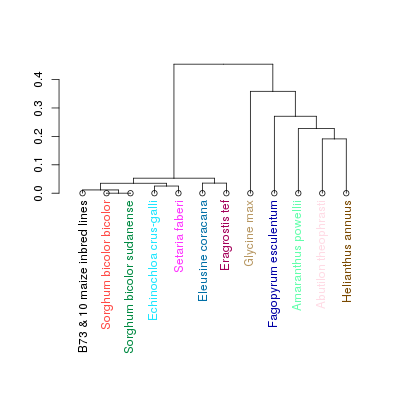

In [9]:
%%R -w 400 -h 400

# simplify, re-order matrix so that plants appear in same order as they are in the legend key.  then 
Mat = phy_expand
colnames(Mat) = c("Fagopyrum esculentum", "Amaranthus powellii", "Helianthus annuus", "Abutilon theophrasti",
                 "Glycine max", "Sorghum bicolor bicolor", "B73 & 10 maize inbred lines", "Echinochloa crus-galli", 
                  "Setaria faberi",  "Eragrostis tef","Eleusine coracana", "75-062", "Oh7B", "MS71", "B97",
                  "H99", "Il14H", "Ki3", "Tx303","Hp301", "Mo18", "Sorghum bicolor sudanense")
rownames(Mat) = c("Fagopyrum esculentum", "Amaranthus powellii", "Helianthus annuus", "Abutilon theophrasti",
                 "Glycine max", "Sorghum bicolor bicolor", "B73 & 10 maize inbred lines", "Echinochloa crus-galli", 
                  "Setaria faberi",  "Eragrostis tef","Eleusine coracana", "75-062", "Oh7B", "MS71", "B97",
                  "H99", "Il14H", "Ki3", "Tx303","Hp301", "Mo18", "Sorghum bicolor sudanense")

Mat = Mat[c("B73 & 10 maize inbred lines",
             "Echinochloa crus-galli", "Setaria faberi", "Sorghum bicolor bicolor", "Sorghum bicolor sudanense",
            "Eleusine coracana", "Eragrostis tef", 
           "Abutilon theophrasti","Helianthus annuus","Fagopyrum esculentum", "Amaranthus powellii","Glycine max"),
         c("B73 & 10 maize inbred lines", 
             "Echinochloa crus-galli", "Setaria faberi", "Sorghum bicolor bicolor", "Sorghum bicolor sudanense",
            "Eleusine coracana", "Eragrostis tef", 
           "Abutilon theophrasti","Helianthus annuus","Fagopyrum esculentum", "Amaranthus powellii","Glycine max"),]

Phy_hc = hclust(as.dist(Mat), "complete")
hcd = as.dendrogram(Phy_hc)
# vector of colors to match CAP plot


# labelColors = c("#1CE6FF", 
#         "#B79762", "#004D43", "#8FB0FF", "#997D87",
#         "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80")
labelColors = c("#000000", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80")

# cut dendrogram in 4 clusters
clusMember = cutree(Phy_hc, 12)
#function to get color labels
colLab <- function(n) {
    if (is.leaf(n)) {
        a <- attributes(n)
        labCol <- labelColors[clusMember[which(names(clusMember) == a$label)]]
        attr(n, "nodePar") <- c(a$nodePar, lab.col = labCol)
    }
    n
}
# using dendrapply
clusDendro = dendrapply(hcd, colLab)
# make plot
par(mar=c(14,4.1,4.1,2.1))
plot(clusDendro, no.margin = TRUE)


# plot(Phy_hc, hang = -1)




In [10]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/plant_phylogeny.pdf", height = 5, width = 7)
par(mar=c(14,4.1,4.1,2.1))
plot(clusDendro, no.margin = TRUE)
dev.off()

png 
  2 


## Create melted dataframes for plot by plot comparisons

In [11]:
%%R
pd.m = melt(as.matrix(phy_expand))

#set column names and create comparison column
colnames(pd.m) = c("PlantA", "PlantB", "phy_Dist")
pd.m$PlantComp = paste(pd.m$PlantA, pd.m$PlantB, sep = "-")
pd.m 


    PlantA PlantB phy_Dist     PlantComp
1    FAGES  FAGES  0.00000   FAGES-FAGES
2    AMAPO  FAGES  0.23210   AMAPO-FAGES
3    HELAN  FAGES  0.25302   HELAN-FAGES
4    ABUTH  FAGES  0.27096   ABUTH-FAGES
5    GLYMA  FAGES  0.35879   GLYMA-FAGES
6    SORBI  FAGES  0.43476   SORBI-FAGES
7      B73  FAGES  0.43787     B73-FAGES
8    ECHCG  FAGES  0.43985   ECHCG-FAGES
9    SETFA  FAGES  0.43592   SETFA-FAGES
10   ERATE  FAGES  0.44622   ERATE-FAGES
11   ELCOR  FAGES  0.44745   ELCOR-FAGES
12  75-062  FAGES  0.43787  75-062-FAGES
13    Oh7B  FAGES  0.43787    Oh7B-FAGES
14    MS71  FAGES  0.43787    MS71-FAGES
15     B97  FAGES  0.43787     B97-FAGES
16     H99  FAGES  0.43787     H99-FAGES
17   Il14H  FAGES  0.43787   Il14H-FAGES
18     Ki3  FAGES  0.43787     Ki3-FAGES
19   Tx303  FAGES  0.43787   Tx303-FAGES
20   Hp301  FAGES  0.43787   Hp301-FAGES
21    Mo18  FAGES  0.43787    Mo18-FAGES
22  SORSUD  FAGES  0.43476  SORSUD-FAGES
23   FAGES  AMAPO  0.23210   FAGES-AMAPO
24   AMAPO  AMAP

In [12]:
%%R
#Read rarified phyloseq object
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)

physeq.Nneg = subset_samples(physeq.Full, Treatment == "Nneg" & Plant != "BARE")
physeq.Nneg = filter_taxa(physeq.Nneg, function(x) sum(x > 0) > 0, TRUE)  
physeq.Nneg

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4927 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4927 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4927 tips and 4926 internal nodes ]


# Overall dataset

In [13]:
%%R

phy = physeq.Nneg

phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4927 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4927 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4927 tips and 4926 internal nodes ]


In [14]:
%%R
registerDoParallel(cores=28)
phy.wunif.dist = distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

### Melt unifrac distances

In [15]:
%%R
ud = as.matrix(phy.wunif.dist) 
# remove lower triangle to remove duplicate values
ud[ lower.tri( ud, diag = TRUE ) ]  <- NA
head(ud)
ud.m = melt(ud, na.rm= TRUE)

# rename columns
colnames(ud.m) = c("PlotA", "PlotB", "w_Unif_Dist")
head(ud.m) %>% print
dim(ud.m) %>% print

                PlotA             PlotB w_Unif_Dist
88  sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072
175 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861
176 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471
262 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018
263 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794
264 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279
[1] 3741    3


### Create seed size  variable

In [16]:
%%R
#add seed size
Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric

## Create functional distance variables
sd = sample_data(phy)

# join seed size with sample data
sd = left_join(sd, SS, by = "Plant")
rownames(sd) = sd$X.sample
sample_data(phy) = sd

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7


In [17]:
%%R
## Create functional distance variables
sd = sample_data(phy)


#measure distances on residCN
CNdist = dist(sd[,"A_Resid_logCN"], method = "euclidian")
    #melt matrix
    CN.m = melt(as.matrix(CNdist))

    #set column names and create comparison column
     colnames(CN.m) = c("PlotA", "PlotB", "CNdist")
    CN.m$PlotComp = paste(CN.m$PlotA, CN.m$PlotB, sep = "-")
    CN.m %>% head %>% print

#measure distances on residBiomass
Ndist = dist(sd[,"A_Resid_logN"], method = "euclidian")
    #melt matrix
    N.m = melt(as.matrix(Ndist))

    #set column names and create comparison column
     colnames(N.m) = c("PlotA", "PlotB", "Ndist")
    N.m$PlotComp = paste(N.m$PlotA, N.m$PlotB, sep = "-")
    N.m %>% head %>% print

#measure distances on Seed Size
SSdist = dist(log(sd[,"SeedSize_mg"]), method = "euclidian")
    #melt matrix
    SS.m = melt(as.matrix(SSdist))

    #set column names and create comparison column
     colnames(SS.m) = c("PlotA", "PlotB", "SSdist")
    SS.m$PlotComp = paste(SS.m$PlotA, SS.m$PlotB, sep = "-")
    SS.m %>% head %>% print


Fun.m = left_join(CN.m, N.m[,c(3,4)], by = "PlotComp")
Fun.m = left_join(Fun.m, SS.m[,c(3,4)], by = "PlotComp")
head(Fun.m)

              PlotA             PlotB     CNdist
1 sample5-1.22_Nneg sample5-1.22_Nneg 0.00000000
2 sample4-2.02_Nneg sample5-1.22_Nneg 0.39380360
3 sample4-4.21_Nneg sample5-1.22_Nneg 0.30193239
4 sample5-2.29_Nneg sample5-1.22_Nneg 0.21610061
5 sample5-2.06_Nneg sample5-1.22_Nneg 0.03917953
6 sample1-2.23_Nneg sample5-1.22_Nneg 0.66441421
                             PlotComp
1 sample5-1.22_Nneg-sample5-1.22_Nneg
2 sample4-2.02_Nneg-sample5-1.22_Nneg
3 sample4-4.21_Nneg-sample5-1.22_Nneg
4 sample5-2.29_Nneg-sample5-1.22_Nneg
5 sample5-2.06_Nneg-sample5-1.22_Nneg
6 sample1-2.23_Nneg-sample5-1.22_Nneg
              PlotA             PlotB     Ndist
1 sample5-1.22_Nneg sample5-1.22_Nneg 0.0000000
2 sample4-2.02_Nneg sample5-1.22_Nneg 0.7647557
3 sample4-4.21_Nneg sample5-1.22_Nneg 0.7766916
4 sample5-2.29_Nneg sample5-1.22_Nneg 0.5096202
5 sample5-2.06_Nneg sample5-1.22_Nneg 0.4174312
6 sample1-2.23_Nneg sample5-1.22_Nneg 1.1123954
                             PlotComp
1 sample5-1.22_Nn

### Join distance tables

In [18]:
%%R
colnames(ud.m)

[1] "PlotA"       "PlotB"       "w_Unif_Dist"


In [19]:
%%R
colnames(sd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[37] "NAG_activity_g"      "BX_rel"              "CB_rel"             
[40] "LAP_rel"             "NAG_rel"             "NO3_ug_g"           
[43] "

In [20]:
%%R
#Add plant names to melted unifrac table
ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotA" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[4] = "PlantA"

ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotB" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[5] = "PlantB"
ud.m$PlantComp = paste(ud.m$PlantA, ud.m$PlantB, sep = "-")

#Create plot-plot variable for joining with functional distance matrix
ud.m$PlotComp = paste(ud.m$PlotA, ud.m$PlotB, sep = "-")
head(ud.m) %>% print

              PlotA             PlotB w_Unif_Dist  Plant
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062
2 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861 75-062
3 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471  SETFA
4 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018 75-062
5 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794  SETFA
6 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279  SETFA
              PlotA             PlotB w_Unif_Dist PlantA  Plant
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062  SETFA
2 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861 75-062  SETFA
3 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471  SETFA  SETFA
4 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018 75-062 75-062
5 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794  SETFA 75-062
6 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279  SETFA 75-062
              PlotA             PlotB w_Unif_Dist PlantA PlantB     PlantComp
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062  SETFA  75-062-SET

### Join with plant phylogenetic distance and functional distance

In [21]:
%%R
colnames(Fun.m)

[1] "PlotA"    "PlotB"    "CNdist"   "PlotComp" "Ndist"    "SSdist"  


In [22]:
%%R
Dist = left_join(ud.m, pd.m[,c(3,4)], by = "PlantComp")
tail(Dist) %>% print

#Join with 
# Join DAP information and library information
Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotA" = "X.sample"))
colnames(Dist)[9:10] = c("LibraryA","DAY_A")
tail(Dist) %>% print

Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotB" = "X.sample"))
colnames(Dist)[11:12] = c("LibraryB","DAY_B")
tail(Dist) %>% print

Dist = left_join(Dist, Fun.m[,3:6], by = "PlotComp")

# set DAY_A and DAY_B as factor
Dist$DAY_A = as.factor(Dist$DAY_A)
Dist$DAY_B = as.factor(Dist$DAY_B)
Dist$TimeDist = abs(as.numeric(as.character(Dist$DAY_A)) - as.numeric(as.character(Dist$DAY_B)))

#create factor for cross library comps and same day comps
Dist$LibraryComp = ifelse(Dist$LibraryA == Dist$LibraryB, 0, 1) %>% as.factor
Dist$SameDay = ifelse(Dist$DAY_A == Dist$DAY_B, 0, 1) %>% as.factor

head(Dist)

                 PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
3736 sample3-2.19_Nneg sample8-3.03_Nneg   0.2419601  ABUTH  ELCOR ABUTH-ELCOR
3737 sample8-1.23_Nneg sample8-3.03_Nneg   0.1984166    Ki3  ELCOR   Ki3-ELCOR
3738 sample6-2.14_Nneg sample8-3.03_Nneg   0.2503097  Hp301  ELCOR Hp301-ELCOR
3739 sample8-4.04_Nneg sample8-3.03_Nneg   0.2377478   Mo18  ELCOR  Mo18-ELCOR
3740 sample3-3.30_Nneg sample8-3.03_Nneg   0.2233484  ABUTH  ELCOR ABUTH-ELCOR
3741 sample7-4.14_Nneg sample8-3.03_Nneg   0.2893173  SORBI  ELCOR SORBI-ELCOR
                                PlotComp phy_Dist
3736 sample3-2.19_Nneg-sample8-3.03_Nneg  0.36639
3737 sample8-1.23_Nneg-sample8-3.03_Nneg  0.05090
3738 sample6-2.14_Nneg-sample8-3.03_Nneg  0.05090
3739 sample8-4.04_Nneg-sample8-3.03_Nneg  0.05090
3740 sample3-3.30_Nneg-sample8-3.03_Nneg  0.36639
3741 sample7-4.14_Nneg-sample8-3.03_Nneg  0.04779
                 PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
3736 sample3-2.19_

## Build corMLPE models

In [51]:
%%R
str(Dist)

'data.frame':	3741 obs. of  18 variables:
 $ PlotA      : chr  "sample5-1.22_Nneg" "sample5-1.22_Nneg" "sample4-2.02_Nneg" "sample5-1.22_Nneg" ...
 $ PlotB      : chr  "sample4-2.02_Nneg" "sample4-4.21_Nneg" "sample4-4.21_Nneg" "sample5-2.29_Nneg" ...
 $ w_Unif_Dist: num  0.207 0.161 0.185 0.151 0.188 ...
 $ PlantA     : Factor w/ 22 levels "75-062","ABUTH",..: 1 1 19 1 19 19 1 19 19 1 ...
 $ PlantB     : Factor w/ 22 levels "75-062","ABUTH",..: 19 19 19 1 1 1 17 17 17 17 ...
 $ PlantComp  : chr  "75-062-SETFA" "75-062-SETFA" "SETFA-SETFA" "75-062-75-062" ...
 $ PlotComp   : chr  "sample5-1.22_Nneg-sample4-2.02_Nneg" "sample5-1.22_Nneg-sample4-4.21_Nneg" "sample4-2.02_Nneg-sample4-4.21_Nneg" "sample5-1.22_Nneg-sample5-2.29_Nneg" ...
 $ phy_Dist   : num  0.0311 0.0311 0 0 0.0311 ...
 $ LibraryA   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_A      : Factor w/ 8 levels "36","53","57",..: 5 5 4 5 4 4 5 4 4 5 ...
 $ LibraryB   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_B      : Factor w/ 8 levels "36"

In [25]:
%%R
#Base models
fitA =  gls(w_Unif_Dist ~ poly(phy_Dist, 2), correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
#Z <- corZ(fit1) #extract correlation structure from previous fit

In [26]:
%%R
summary(fitA)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ poly(phy_Dist, 2) 
  Data: Dist 
        AIC       BIC   logLik
  -12063.97 -12032.84 6036.987

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2240349 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.2503534 0.00634975  39.42729       0
poly(phy_Dist, 2)1  1.4608596 0.09018650  16.19821       0
poly(phy_Dist, 2)2 -1.0478436 0.08046409 -13.02250       0

 Correlation: 
                   (Intr) p(_D,2)1
poly(phy_Dist, 2)1  0.000         
poly(phy_Dist, 2)2  0.000 -0.441  

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.6863034 -0.7135706 -0.1466390  0.6108949  4.3143161 

Residual standard error: 0.06212125 
Degrees of freedom: 3741 total; 3738 residual


In [34]:
%%R
fitB.1 =  gls(w_Unif_Dist ~ TimeDist, correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
#Z <- corZ(fit1) #extract correlation structure from previous fit

In [35]:
%%R
summary(fitB.1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist 
  Data: Dist 
        AIC       BIC   logLik
  -12272.79 -12247.88 6140.393

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2696442 

Coefficients:
                 Value   Std.Error  t-value p-value
(Intercept) 0.22308814 0.007451040 29.94054       0
TimeDist    0.00180863 0.000077516 23.33222       0

 Correlation: 
         (Intr)
TimeDist -0.157

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3030923 -0.7273081 -0.1503723  0.6002834  4.2673245 

Residual standard error: 0.06576529 
Degrees of freedom: 3741 total; 3739 residual


In [124]:
%%R
#Base models
fitB =  gls(w_Unif_Dist ~ poly(TimeDist,2), correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
#Z <- corZ(fit1) #extract correlation structure from previous fit

In [125]:
%%R
summary(fitB)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ poly(TimeDist, 2) 
  Data: Dist 
        AIC       BIC   logLik
  -12340.66 -12309.52 6175.328

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2684808 

Coefficients:
                        Value  Std.Error  t-value p-value
(Intercept)         0.2503534 0.00726745 34.44859       0
poly(TimeDist, 2)1  1.2607650 0.06124728 20.58483       0
poly(TimeDist, 2)2 -0.4228026 0.05410801 -7.81405       0

 Correlation: 
                   (Intr) p(TD,2)1
poly(TimeDist, 2)1 0.000          
poly(TimeDist, 2)2 0.000  0.266   

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3792181 -0.7404503 -0.1472129  0.5980254  4.2597583 

Residual standard error: 0.06508614 
Degrees of freedom: 3741 total; 3738 residual


In [126]:
%%R
#Base models
fitC =  gls(w_Unif_Dist ~ SameDay, correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
#Z <- corZ(fit1) #extract correlation structure from previous fit

In [127]:
%%R
summary(fitC)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay 
  Data: Dist 
        AIC       BIC   logLik
  -12149.62 -12124.72 6078.811

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2645287 

Coefficients:
                 Value   Std.Error  t-value p-value
(Intercept) 0.21387120 0.007564568 28.27276       0
SameDay1    0.04286432 0.002148592 19.94995       0

 Correlation: 
         (Intr)
SameDay1 -0.242

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.0814933 -0.7355399 -0.1276401  0.5957897  4.4675883 

Residual standard error: 0.06621635 
Degrees of freedom: 3741 total; 3739 residual


In [129]:
%%R
fitD = gls(w_Unif_Dist ~ SameDay + TimeDist, correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)

In [130]:
%%R
summary(fitD)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + TimeDist 
  Data: Dist 
        AIC       BIC   logLik
  -12349.77 -12318.64 6179.886

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2700182 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.21005450 0.007500760 28.004428       0
SameDay1    0.02334228 0.002457563  9.498139       0
TimeDist    0.00135535 0.000090257 15.016605       0

 Correlation: 
         (Intr) SamDy1
SameDay1 -0.183       
TimeDist -0.034 -0.529

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.2989242 -0.7325711 -0.1417937  0.5900034  4.3442430 

Residual standard error: 0.06504508 
Degrees of freedom: 3741 total; 3738 residual


In [132]:
%%R
anova(fitA, fitB, fitC, fitD)

     Model df       AIC       BIC   logLik   Test  L.Ratio p-value
fitA     1  5 -12063.97 -12032.84 6036.987                        
fitB     2  5 -12340.66 -12309.52 6175.328                        
fitC     3  4 -12149.62 -12124.72 6078.811 2 vs 3 193.0338  <.0001
fitD     4  5 -12349.77 -12318.64 6179.886 3 vs 4 202.1516  <.0001


In [52]:
%%R
#Base models
fit1 =  gls(w_Unif_Dist ~ 1, correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
#Z <- corZ(fit1) #extract correlation structure from previous fit

In [53]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: Dist 
        AIC       BIC   logLik
  -11783.89 -11765.21 5894.943

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2574348 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.2503534 0.00751048 33.33388       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.2180940 -0.7392044 -0.1107053  0.6166584  4.4016003 

Residual standard error: 0.06865901 
Degrees of freedom: 3741 total; 3740 residual


In [54]:
%%R
#Controlling for time and batch effects, using same correlation structure
fit2 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
summary(fit2)


Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp 
  Data: Dist 
        AIC       BIC   logLik
  -12384.39 -12347.04 6198.196

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2713274 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.20907319 0.007491278 27.908881       0
TimeDist     0.00125187 0.000090928 13.767600       0
SameDay1     0.02002566 0.002488400  8.047607       0
LibraryComp1 0.01071976 0.001546897  6.929847       0

 Correlation: 
             (Intr) TimDst SamDy1
TimeDist     -0.030              
SameDay1     -0.175 -0.480       
LibraryComp1 -0.019 -0.164 -0.192

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3629865 -0.7375187 -0.1300982  0.5913381  4.3035691 

Residual standard error: 0.06481688 
Degrees of freedom: 3741 total; 3737 residual


In [ ]:
%%R
fit2a =  gls(w_Unif_Dist ~ TimeDist + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
summary(fit2a)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + LibraryComp 
  Data: Dist 
        AIC       BIC   logLik
  -12332.32 -12301.19 6171.161

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2709838 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.21962195 0.007428668 29.564108       0
TimeDist     0.00160329 0.000080433 19.933284       0
LibraryComp1 0.01311274 0.001530988  8.564887       0

 Correlation: 
             (Intr) TimDst
TimeDist     -0.132       
LibraryComp1 -0.054 -0.298

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3815863 -0.7356423 -0.1358884  0.5944086  4.2335854 

Residual standard error: 0.06532035 
Degrees of freedom: 3741 total; 3738 residual


In [ ]:
%%R
#Hypothesis testing functional distance
fit3 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + Ndist + SSdist + CNdist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
summary(fit3)

In [59]:
%%R
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + Ndist + SSdist +      CNdist 
  Data: Dist 
        AIC       BIC   logLik
  -12357.94 -12301.91 6187.968

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2684895 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.20829229 0.007523704 27.684808  0.0000
TimeDist      0.00128624 0.000091761 14.017285  0.0000
SameDay1      0.01774300 0.002611127  6.795150  0.0000
LibraryComp1  0.01080933 0.001549175  6.977476  0.0000
Ndist        -0.00470371 0.002401811 -1.958400  0.0503
SSdist        0.00132767 0.000391163  3.394165  0.0007
CNdist        0.00225432 0.004365302  0.516419  0.6056

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1 Ndist  SSdist
TimeDist     -0.018                                   
SameDay1     -0.127 -0.462                            
LibraryComp1 -0.027 -0.167 -0.195                     
Ndi

In [ ]:
%%R
#H2: phylogenetic dist
fit4 =  gls(w_Unif_Dist ~ TimeDist + phy_Dist + SameDay + LibraryComp, 
            correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
summary(fit4)

In [60]:
%%R
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + phy_Dist + SameDay + LibraryComp 
  Data: Dist 
        AIC       BIC   logLik
  -12381.33 -12337.75 6197.665

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2657677 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.20725521 0.007367031 28.132801  0.0000
TimeDist     0.00115488 0.000098034 11.780471  0.0000
phy_Dist     0.02028344 0.007713622  2.629561  0.0086
SameDay1     0.01961004 0.002492782  7.866729  0.0000
LibraryComp1 0.01130321 0.001562220  7.235348  0.0000

 Correlation: 
             (Intr) TimDst phy_Ds SamDy1
TimeDist      0.007                     
phy_Dist     -0.094 -0.375              
SameDay1     -0.171 -0.420 -0.065       
LibraryComp1 -0.032 -0.204  0.142 -0.199

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3353821 -0.7334692 -0.1418976  0.6091997  4.3350587 

Residual standar

In [61]:
%%R
fit5 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) 
  Data: Dist 
        AIC       BIC   logLik
  -12502.55 -12452.74 6259.274

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2516585 

Coefficients:
                        Value  Std.Error    t-value p-value
(Intercept)         0.2138670 0.00688717  31.052962       0
TimeDist            0.0011882 0.00009657  12.303691       0
SameDay1            0.0154438 0.00248397   6.217391       0
LibraryComp1        0.0108511 0.00153963   7.047826       0
poly(phy_Dist, 2)1  0.6905091 0.09452696   7.304890       0
poly(phy_Dist, 2)2 -0.8580105 0.07699515 -11.143696       0

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1
TimeDist           -0.060                              
SameDay1           -0.197 -0.420                       
LibraryComp1       -0.009 -0.205 -0.193                
poly(phy_Dist, 2)1  0.093

In [63]:
%%R
#H3: combined phylogenetic distance and functional
fit6=  gls(w_Unif_Dist ~ TimeDist  + SameDay + LibraryComp + poly(phy_Dist,2) + SSdist + Ndist + CNdist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) + SSdist + Ndist + CNdist 
  Data: Dist 
        AIC       BIC   logLik
  -12477.65 -12409.18 6249.827

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2491351 

Coefficients:
                        Value  Std.Error    t-value p-value
(Intercept)         0.2163807 0.00700372  30.895120  0.0000
TimeDist            0.0012291 0.00009770  12.579487  0.0000
SameDay1            0.0145394 0.00258928   5.615234  0.0000
LibraryComp1        0.0107754 0.00153865   7.003177  0.0000
poly(phy_Dist, 2)1  0.7182261 0.10112856   7.102110  0.0000
poly(phy_Dist, 2)2 -0.8772200 0.07759206 -11.305539  0.0000
SSdist              0.0008732 0.00039773   2.195454  0.0282
Ndist              -0.0076815 0.00240110  -3.199178  0.0014
CNdist             -0.0023935 0.00431821  -0.554280  0.5794

 Correlation: 
                   (Intr) TimDst SamDy1 Lbr

In [64]:
%%R
#H3: combined phylogenetic distance and functional
fit7=  gls(w_Unif_Dist ~ TimeDist + SSdist + Ndist + CNdist,  
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
summary(fit7)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SSdist + Ndist + CNdist 
  Data: Dist 
        AIC       BIC   logLik
  -12267.02 -12223.44 6140.512

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2656204 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.21809746 0.007489513 29.120378   0.000
TimeDist     0.00177752 0.000078968 22.509205   0.000
SSdist       0.00211529 0.000381896  5.538915   0.000
Ndist       -0.00598838 0.002435393 -2.458898   0.014
CNdist       0.00749934 0.004394333  1.706594   0.088

 Correlation: 
         (Intr) TimDst SSdist Ndist 
TimeDist -0.109                     
SSdist   -0.104 -0.074              
Ndist    -0.084 -0.137 -0.262       
CNdist   -0.130 -0.077  0.028 -0.206

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3602048 -0.7295764 -0.1354639  0.5952868  4.3679680 

Residual standard error: 0.06495687 
Degrees 

In [598]:
%%R
fit9=  gls(w_Unif_Dist ~ TimeDist + poly(phy_Dist,2) + Bdist + SSdist + CNdist, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit9)


Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) + Bdist + SSdist + CNdist 
  Data: Dist 
       AIC       BIC   logLik
  -12470.3 -12401.82 6246.148

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2507034 

Coefficients:
                        Value  Std.Error    t-value p-value
(Intercept)         0.2153904 0.00707501  30.443822  0.0000
TimeDist            0.0012131 0.00009762  12.425896  0.0000
SameDay1            0.0148830 0.00259451   5.736341  0.0000
LibraryComp1        0.0107912 0.00154129   7.001432  0.0000
poly(phy_Dist, 2)1  0.6823931 0.10060775   6.782710  0.0000
poly(phy_Dist, 2)2 -0.8665307 0.07763969 -11.160925  0.0000
Bdist              -0.0043929 0.00271744  -1.616545  0.1061
SSdist              0.0007513 0.00039854   1.885179  0.0595
CNdist             -0.0052543 0.00425177  -1.235792  0.2166

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC

In [600]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6, fit7, fit8, fit9)


Error in nlme::anova.lme(object = fit1, fit2, fit3, fit4, fit5, fit6,  : 
  all fitted objects must use the same number of observations


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In nlme::anova.lme(object = fit1, fit2, fit3, fit4, fit5, fit6,  :
  res = super(Function, self).__call__(*new_args, **new_kwargs)


Notes: Phylogenetic distance^2 and time make the best model on the overall dataset of annuals plus B73

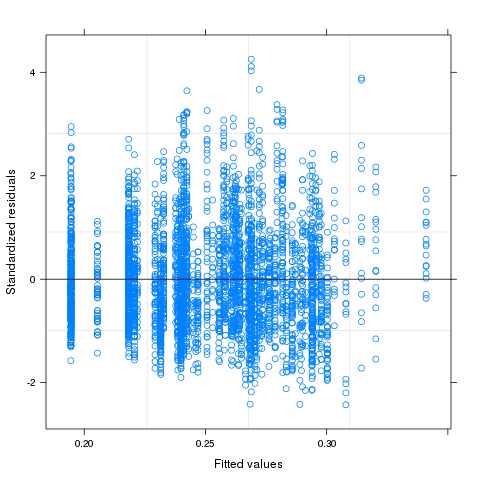

In [92]:
%%R
plot(fit5)

## Graphs

### phylogenetic distance vs microbial community

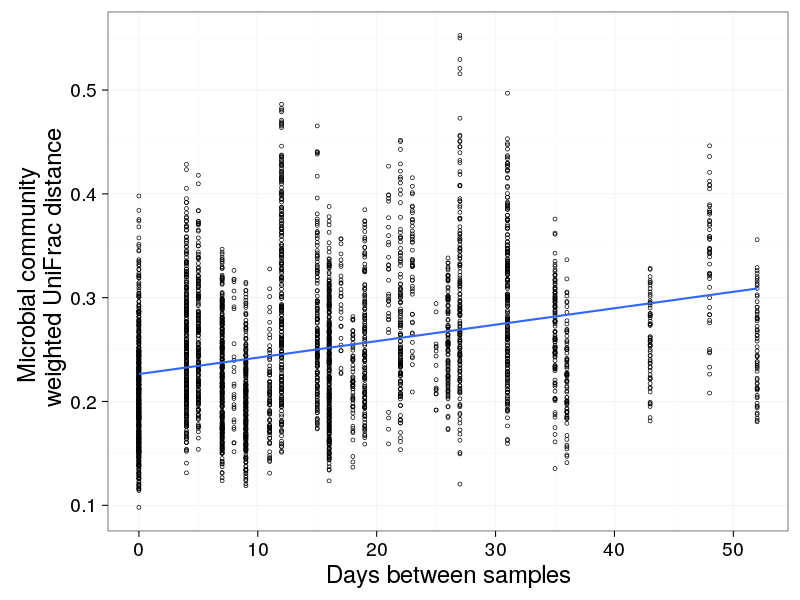

In [87]:
%%R -w 800 -h 600
test <- function(x) {-.858*x ^ 2 + .69*x + .213}

               
p = ggplot(Dist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p = p + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
p = p + stat_smooth(method = "lm", se = FALSE)
p = p + theme_bw(base_size = 24)
p = p + theme(panel.border = element_blank()) 
p = p + theme(axis.line.x = element_line(color="black", size = 1),
    axis.line.y = element_line(color="black", size = 1))

# p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
# p = p + stat_function(fun = test)
# p = p + stat_smooth(method = "lm", se = FALSE)
p = p + labs(x = "Plant phylogenetic distance")
p = p + labs(y = "Microbial community \n weighted UniFrac distance")
p


p1 = ggplot(Dist, aes(y = w_Unif_Dist, x = TimeDist)) 
p1 = p1 + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
p1 = p1 + stat_smooth(method = "lm", se = FALSE)
p1 = p1 + theme_bw(base_size = 24)
#p1 = p1 + ggtitle("Time")
#p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
#p1 = p1 + stat_function(fun = test)
p1 = p1 + labs(x = "Days between samples")
p1 = p1 + labs(y = "Microbial community \n weighted UniFrac distance")
#p1 = p1 + theme(axis.title.y = element_blank())
#p1 = p1 + labs(y = "Weighted UniFrac distance")
p1

# p2 = ggplot(Dist, aes(y = w_Unif_Dist, x = SSdist)) 
# p2 = p2 + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
# p2 = p2 + stat_smooth(method = "lm", se = FALSE)
# p2 = p2 + theme_bw(base_size = 16)
# p2 = p2 + ggtitle("Plant Growth and N Uptake")
# #p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
# #p1 = p1 + stat_function(fun = test)
# p2 = p2 + labs(x = "PCA distance")
# p2 = p2 + labs(y = "Weighted UniFrac distance")
# p2


# p3 =    ggplot(Dist, aes(x = SameDay, y = w_Unif_Dist))  +
#        geom_boxplot() +
#         theme(axis.title.x = element_blank())+ 
#         ylab("Weighted UniFrac distance") +
#         ggtitle("Sampling Date") +
#         theme_bw(base_size = 16)+
#         theme(axis.title.x = element_blank()) +
#         theme(legend.position="none")

# grid.arrange(p, p1, p2, p3, ncol = 2)

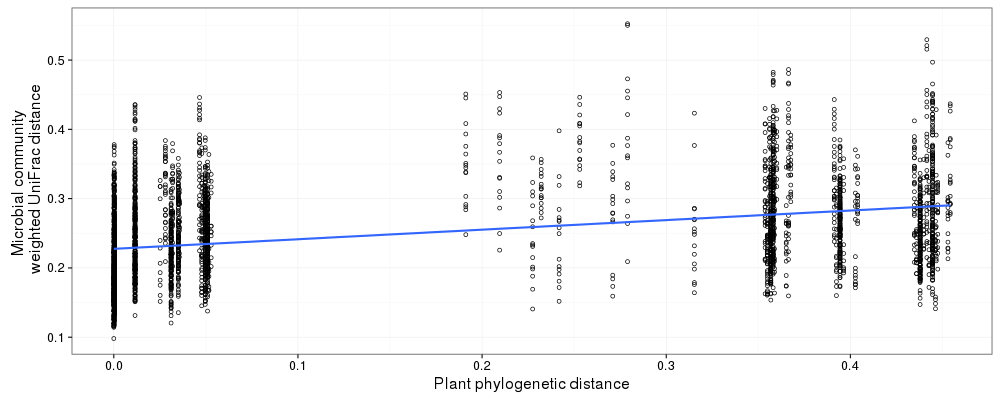

In [636]:
%%R -w 1000 -h 400
p


In [647]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/MCCcorr.pdf", height = 5, width = 12)
p %>% print
dev.off()

png 
  2 


In [641]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/MCCcorr.pdf", height = 3.5, width = 4)
grid.arrange(p) %>% print
dev.off()

TableGrob (1 x 1) "arrange": 1 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
png 
  2 


### intra vs interspecific variation

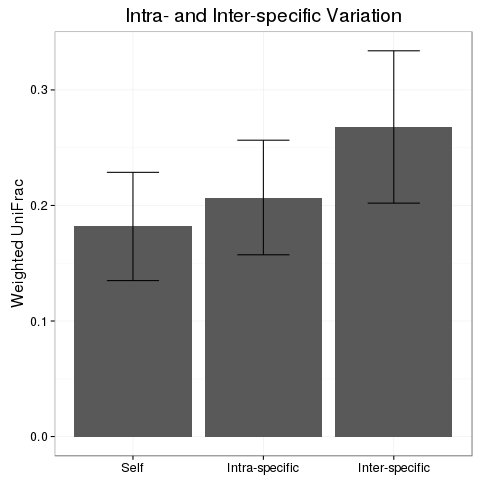

In [505]:
%%R
# define subsets of genotype vs within species vs between species
# phy dist = 0.00, 0.0002, > 0.0002
Dist %>%
  mutate(Related = ifelse(phy_Dist == 0, "Self",
               ifelse(phy_Dist == 0.0002, "Intra-specific", "Inter-specific"))) %>%
    group_by(Related) %>%
    summarise(w_Unif = mean(w_Unif_Dist),
              w_Unif.sd = sd(w_Unif_Dist),
            w_Unif.se = sd(w_Unif_Dist)/sqrt(length(w_Unif_Dist)),
             n = length(w_Unif_Dist)) %>% 

    arrange(w_Unif) %>%

    mutate(Related = factor(Related, Related)) %>%

    ggplot(aes(x = Related, y = w_Unif))  +
        geom_bar(stat = "identity") +
      geom_errorbar(aes(y = w_Unif,
                  ymin = w_Unif - w_Unif.sd, ymax = w_Unif + w_Unif.sd),
                   colour = 'black', width = 0.4) +
        theme(axis.title.x = element_blank())+ 
        ylab("Weighted UniFrac") +
        ggtitle("Intra- and Inter-specific Variation") +
        theme_bw(base_size = 16)+
        theme(axis.title.x = element_blank()) +
        theme(legend.position="none")



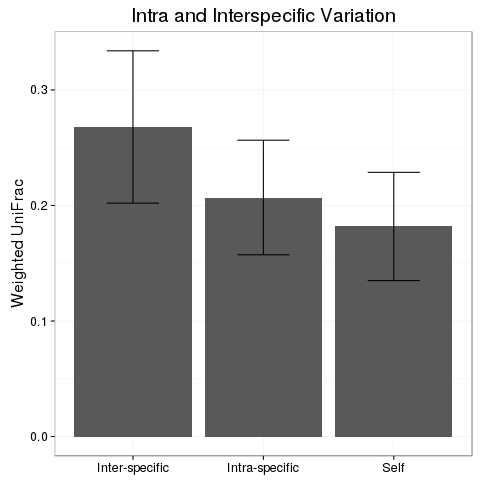

In [496]:
%%R
P = ggplot(df, aes(x = Related, y = w_Unif))  +
        geom_bar(stat = "identity") + 
        geom_errorbar(data = df, aes(y = w_Unif,
                  ymin = w_Unif - w_Unif.sd, ymax = w_Unif + w_Unif.sd),
                   colour = 'black', width = 0.4) +
        theme(axis.title.x = element_blank())+ 
        ylab("Weighted UniFrac") +
        ggtitle("Intra and Interspecific Variation") +
        theme_bw(base_size = 16)+
        theme(axis.title.x = element_blank()) +
        theme(legend.position="none")
P

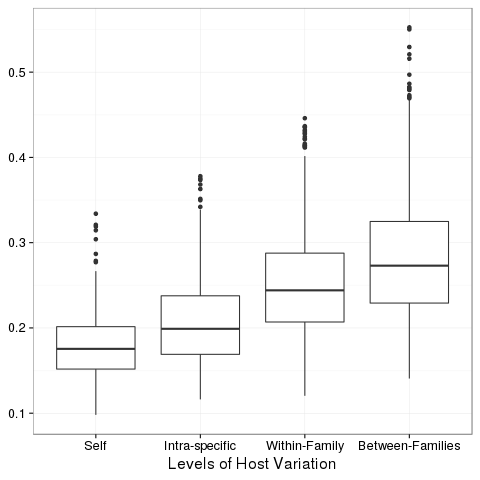

In [84]:
%%R
p4 = Dist %>%
    mutate(Related = ifelse(phy_Dist == 0, "Self",
               ifelse(phy_Dist == 0.0002, "Intra-specific", #"Interspecific"))) %>%
                ifelse(phy_Dist < 0.1, "Within-Family", "Between-Families")))) %>%


    mutate(Related = factor(Related, c("Self","Intra-specific", "Within-Family", "Between-Families" ))) %>%

 ggplot(aes(x = Related, y = w_Unif_Dist))  +
       geom_boxplot() +

#         ylab("Weighted UniFrac") +
        #ggtitle("Intra- and Interspecific Variation") +
        theme_bw(base_size = 16)+
       # theme(axis.title.x = element_blank()) +
        theme(axis.title.y = element_blank()) +
        theme(legend.position="none")+ 
        xlab("Levels of Host Variation")
p4

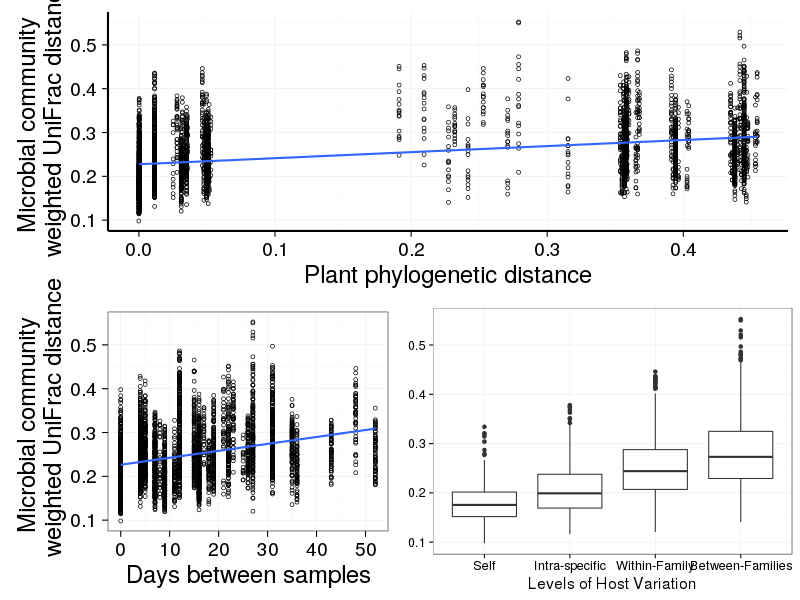

In [88]:
%%R -w 800 -h 600
grid.arrange(p,p1,p4, layout_matrix = rbind(c(1, 1), c(2,3)))

# GLS if self comparisons are removed

In [27]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, phy_Dist > 0.000)
dim(SubDist)

[1] 3741   18
[1] 3612   18


In [29]:
%%R

fit_DS_t =  gls(w_Unif_Dist ~ TimeDist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_DS_t)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist 
  Data: SubDist 
        AIC       BIC   logLik
  -12083.28 -12058.51 6045.638

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2870025 

Coefficients:
                 Value   Std.Error  t-value p-value
(Intercept) 0.22880177 0.007721744 29.63084       0
TimeDist    0.00153702 0.000081104 18.95123       0

 Correlation: 
         (Intr)
TimeDist -0.164

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.2697804 -0.7286537 -0.1499674  0.6031972  4.2756063 

Residual standard error: 0.06601678 
Degrees of freedom: 3612 total; 3610 residual


In [28]:
%%R

fit_DS_tt =  gls(w_Unif_Dist ~ poly(TimeDist, 2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_DS_tt)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ poly(TimeDist, 2) 
  Data: SubDist 
        AIC       BIC   logLik
  -12127.53 -12096.57 6068.764

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2863537 

Coefficients:
                        Value  Std.Error  t-value p-value
(Intercept)         0.2528009 0.00755991 33.43965       0
poly(TimeDist, 2)1  1.0416098 0.06284723 16.57368       0
poly(TimeDist, 2)2 -0.3251493 0.05329241 -6.10123       0

 Correlation: 
                   (Intr) p(TD,2)1
poly(TimeDist, 2)1 0.00           
poly(TimeDist, 2)2 0.00   0.28    

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3250061 -0.7339531 -0.1356121  0.5938031  4.2627414 

Residual standard error: 0.06559227 
Degrees of freedom: 3612 total; 3609 residual


In [30]:
%%R

fit_DS_s =  gls(w_Unif_Dist ~ SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_DS_s)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay 
  Data: SubDist 
        AIC       BIC   logLik
  -11925.79 -11901.02 5966.893

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2831699 

Coefficients:
                 Value   Std.Error  t-value p-value
(Intercept) 0.22467287 0.007952525 28.25177       0
SameDay1    0.03190055 0.002360765 13.51280       0

 Correlation: 
         (Intr)
SameDay1 -0.262

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.0559497 -0.7330030 -0.1258194  0.6003666  4.4203800 

Residual standard error: 0.0669602 
Degrees of freedom: 3612 total; 3610 residual


In [31]:
%%R

fit_DS_st =  gls(w_Unif_Dist ~ TimeDist + SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_DS_st)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay 
  Data: SubDist 
        AIC       BIC   logLik
  -12103.72 -12072.77 6056.861

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2867294 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.21951238 0.007850183 27.962708       0
TimeDist    0.00129565 0.000091129 14.217686       0
SameDay1    0.01481274 0.002592111  5.714546       0

 Correlation: 
         (Intr) TimDst
TimeDist -0.046       
SameDay1 -0.207 -0.463

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.2659874 -0.7313349 -0.1414259  0.5855155  4.3120774 

Residual standard error: 0.06568882 
Degrees of freedom: 3612 total; 3609 residual


In [32]:
%%R

fit_DS_p =  gls(w_Unif_Dist ~ poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_DS_p)


Generalized least squares fit by REML
  Model: w_Unif_Dist ~ poly(phy_Dist, 2) 
  Data: SubDist 
        AIC       BIC   logLik
  -11808.81 -11777.85 5909.405

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2446601 

Coefficients:
                        Value  Std.Error  t-value p-value
(Intercept)         0.2527909 0.00672042 37.61533       0
poly(phy_Dist, 2)1  0.9100699 0.11971187  7.60217       0
poly(phy_Dist, 2)2 -0.6879113 0.10210700 -6.73716       0

 Correlation: 
                   (Intr) p(_D,2)1
poly(phy_Dist, 2)1  0.00          
poly(phy_Dist, 2)2  0.00  -0.66   

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3669375 -0.7290327 -0.1414150  0.6117753  4.3003563 

Residual standard error: 0.06296981 
Degrees of freedom: 3612 total; 3609 residual


In [33]:
%%R

fit_DS_stp =  gls(w_Unif_Dist ~ TimeDist + SameDay + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_DS_stp)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + poly(phy_Dist, 2) 
  Data: SubDist 
        AIC       BIC   logLik
  -12146.68 -12103.34 6080.339

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2700101 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.2186538 0.00734696 29.761112  0.0000
TimeDist            0.0013752 0.00009551 14.397955  0.0000
SameDay1            0.0143804 0.00257955  5.574790  0.0000
poly(phy_Dist, 2)1  0.3311698 0.11970263  2.766604  0.0057
poly(phy_Dist, 2)2 -0.6874612 0.09855690 -6.975272  0.0000

 Correlation: 
                   (Intr) TimDst SamDy1 p(_D,2)1
TimeDist           -0.063                       
SameDay1           -0.218 -0.451                
poly(phy_Dist, 2)1  0.041 -0.233  0.019         
poly(phy_Dist, 2)2 -0.001 -0.016  0.014 -0.646  

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.36

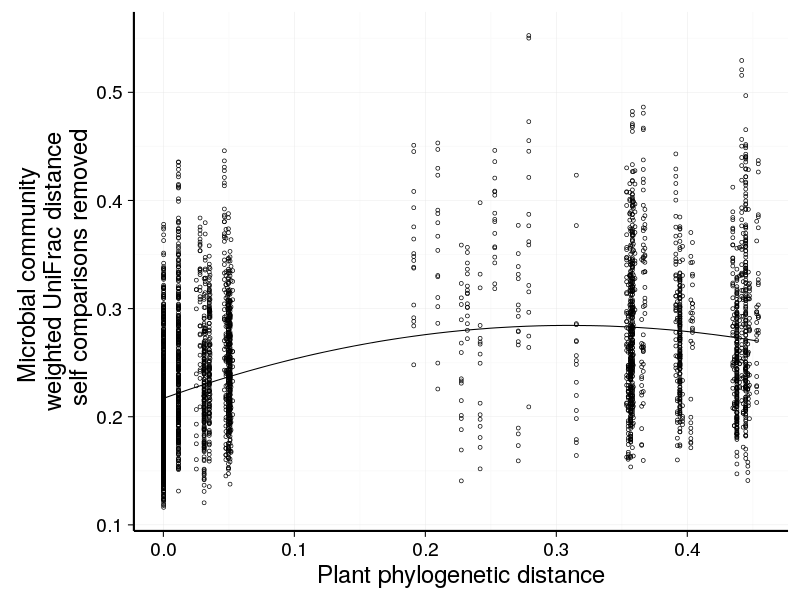

In [121]:
%%R -w 800 -h 600
test <- function(x) {-.701*x ^ 2 + .435*x + .217}

p = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p = p + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", se = FALSE)
p = p + theme_bw(base_size = 24)
p = p + theme(panel.border = element_blank()) 
p = p + theme(axis.line.x = element_line(color="black", size = 1),
    axis.line.y = element_line(color="black", size = 1))

# p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
p = p + stat_function(fun = test)
# p = p + stat_smooth(method = "lm", se = FALSE)
p = p + labs(x = "Plant phylogenetic distance")
p = p + labs(y = "Microbial community \n weighted UniFrac distance \n self comparisons removed")
p

# GLS if intraspecific and self comparisons are removed

## Is sample date more informative than time once self and intra-specific comparisons are removed

In [36]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, phy_Dist > 0.003)
dim(SubDist) %>% print


[1] 3741   18
[1] 2716   18


In [116]:
%%R

fit_ds1 =  gls(w_Unif_Dist ~ SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_ds1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay 
  Data: SubDist 
        AIC       BIC   logLik
  -8748.342 -8724.718 4378.171

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
     Rho 
0.261462 

Coefficients:
                 Value   Std.Error  t-value p-value
(Intercept) 0.21111869 0.008114730 26.01672       0
SameDay1    0.04879541 0.003769404 12.94513       0

 Correlation: 
         (Intr)
SameDay1 -0.437

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.11673194 -0.57448135  0.04605114  0.75999517  4.44195150 

Residual standard error: 0.06588294 
Degrees of freedom: 2716 total; 2714 residual


In [37]:
%%R

fit_ds2 =  gls(w_Unif_Dist ~ TimeDist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_ds2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist 
  Data: SubDist 
        AIC       BIC   logLik
  -8832.812 -8809.188 4420.406

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2690645 

Coefficients:
                 Value   Std.Error  t-value p-value
(Intercept) 0.23104818 0.007555870 30.57863       0
TimeDist    0.00148255 0.000090664 16.35215       0

 Correlation: 
         (Intr)
TimeDist -0.21 

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.28999174 -0.58080086  0.02360467  0.74334256  4.27966007 

Residual standard error: 0.06577294 
Degrees of freedom: 2716 total; 2714 residual


In [38]:
%%R
fit_ds3 =  gls(w_Unif_Dist ~ poly(TimeDist, 2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_ds3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ poly(TimeDist, 2) 
  Data: SubDist 
        AIC       BIC   logLik
  -8901.364 -8871.835 4455.682

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2704501 

Coefficients:
                        Value  Std.Error  t-value p-value
(Intercept)         0.2578574 0.00734522 35.10549       0
poly(TimeDist, 2)1  0.8314166 0.06349334 13.09455       0
poly(TimeDist, 2)2 -0.4543972 0.05766800 -7.87954       0

 Correlation: 
                   (Intr) p(TD,2)1
poly(TimeDist, 2)1 0.012          
poly(TimeDist, 2)2 0.006  0.324   

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3807145 -0.5754508  0.0334641  0.7583578  4.2436324 

Residual standard error: 0.06522988 
Degrees of freedom: 2716 total; 2713 residual


In [40]:
%%R

fit_ds4 =  gls(w_Unif_Dist ~ poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_ds4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ poly(phy_Dist, 2) 
  Data: SubDist 
        AIC       BIC   logLik
  -8607.228 -8577.699 4308.614

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2299531 

Coefficients:
                        Value  Std.Error  t-value p-value
(Intercept)         0.2598942 0.00667707 38.92341   0e+00
poly(phy_Dist, 2)1  0.4868670 0.11454472  4.25045   0e+00
poly(phy_Dist, 2)2 -0.4720596 0.11697261 -4.03564   1e-04

 Correlation: 
                   (Intr) p(_D,2)1
poly(phy_Dist, 2)1  0.079         
poly(phy_Dist, 2)2 -0.083 -0.669  

Standardized residuals:
         Min           Q1          Med           Q3          Max 
-2.229090837 -0.609663075 -0.007727679  0.741762512  4.232338518 

Residual standard error: 0.06382855 
Degrees of freedom: 2716 total; 2713 residual


# GLS if only same day plants are compared

In [670]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, SameDay == 0)


dim(SubDist) %>% print
SubDist$PlantA %>% unique


[1] 3741   22
[1] 557  22
 [1] SETFA  75-062 B73    MS71   FAGES  Oh7B   B97    H99    Il14H  GLYMA 
[11] AMAPO  ERATE  ELCOR  SORSUD SORBI  HELAN  Ki3    Hp301  ECHCG  Tx303 
[21] Mo18   ABUTH 
22 Levels: 75-062 ABUTH AMAPO B73 B97 ECHCG ELCOR ERATE FAGES GLYMA ... Tx303


In [671]:
%%R
fitSameDay0_a =  gls(w_Unif_Dist ~ phy_Dist, correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fitSameDay0_a)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ phy_Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -1845.611 -1828.335 926.8054

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2034893 

Coefficients:
                Value   Std.Error  t-value p-value
(Intercept) 0.1981190 0.005544482 35.73264       0
phy_Dist    0.1173023 0.022145088  5.29699       0

 Correlation: 
         (Intr)
phy_Dist -0.243

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.9257419 -0.6865501 -0.1091856  0.6224320  3.4666207 

Residual standard error: 0.05195799 
Degrees of freedom: 557 total; 555 residual


In [672]:
%%R
fitSameDay0_b =  gls(w_Unif_Dist ~ poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fitSameDay0_b)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ poly(phy_Dist, 2) 
  Data: SubDist 
        AIC       BIC   logLik
  -1857.397 -1835.812 933.6987

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
     Rho 
0.203791 

Coefficients:
                        Value  Std.Error  t-value p-value
(Intercept)         0.2042236 0.00532399 38.35910   0e+00
poly(phy_Dist, 2)1  0.2647764 0.05357727  4.94195   0e+00
poly(phy_Dist, 2)2 -0.2274949 0.05668382 -4.01340   1e-04

 Correlation: 
                   (Intr) p(_D,2)1
poly(phy_Dist, 2)1 -0.064         
poly(phy_Dist, 2)2 -0.033  0.100  

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.9880361 -0.6952600 -0.1074439  0.5571841  3.5120538 

Residual standard error: 0.0512834 
Degrees of freedom: 557 total; 554 residual


In [677]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, SameDay == 0 & phy_Dist > 0.000)
dim(SubDist)


fitSD_dropself_a =  gls(w_Unif_Dist ~ poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fitSD_dropself_a)

[1] 3741   22
Generalized least squares fit by REML
  Model: w_Unif_Dist ~ poly(phy_Dist, 2) 
  Data: SubDist 
        AIC       BIC   logLik
  -1465.722 -1445.461 737.8609

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2501031 

Coefficients:
                        Value  Std.Error  t-value p-value
(Intercept)         0.2125537 0.00623859 34.07080  0.0000
poly(phy_Dist, 2)1  0.2610183 0.08379096  3.11511  0.0020
poly(phy_Dist, 2)2 -0.1422964 0.08719410 -1.63195  0.1034

 Correlation: 
                   (Intr) p(_D,2)1
poly(phy_Dist, 2)1 -0.217         
poly(phy_Dist, 2)2 -0.004 -0.008  

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.9310926 -0.7330344 -0.1046053  0.5836328  3.3770178 

Residual standard error: 0.05122291 
Degrees of freedom: 428 total; 425 residual


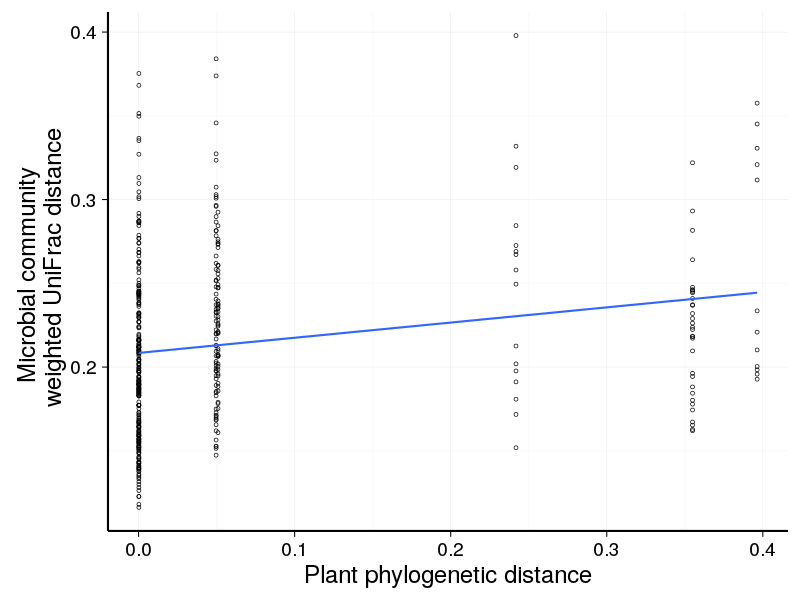

In [678]:
%%R -w 800 -h 600
#test <- function(x) {-.858*x ^ 2 + .69*x + .213}

               
p = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p = p + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
p = p + stat_smooth(method = "lm", se = FALSE)
p = p + theme_bw(base_size = 24)
p = p + theme(panel.border = element_blank()) 
p = p + theme(axis.line.x = element_line(color="black", size = 1),
    axis.line.y = element_line(color="black", size = 1))

# p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
# p = p + stat_function(fun = test)
# p = p + stat_smooth(method = "lm", se = FALSE)
p = p + labs(x = "Plant phylogenetic distance")
p = p + labs(y = "Microbial community \n weighted UniFrac distance")
p_SD_dropself = p
p_SD_dropself

# GLS on species comparisons

In [93]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, phy_Dist > 0.003)
SubDist = filter(SubDist, PlantA %in% c("B73",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN", "FAGES", "AMAPO", "ECHCG", "GLYMA", "SETFA", "ABUTH") &
                PlantB %in% c("B73",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN", "FAGES", "AMAPO", "ECHCG", "GLYMA", "SETFA", "ABUTH"))
dim(SubDist) %>% print



[1] 3741   18
[1] 996  18


In [94]:
%%R
fit_t =  gls(w_Unif_Dist ~ TimeDist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [98]:
%%R
summary(fit_t)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist 
  Data: SubDist 
        AIC       BIC   logLik
  -3044.262 -3024.655 1526.131

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2616003 

Coefficients:
                 Value   Std.Error  t-value p-value
(Intercept) 0.25699992 0.010813148 23.76735       0
TimeDist    0.00157976 0.000134793 11.71992       0

 Correlation: 
         (Intr)
TimeDist -0.246

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.4870127 -0.7483588 -0.1053911  0.6205608  3.6395720 

Residual standard error: 0.06948877 
Degrees of freedom: 996 total; 994 residual


In [109]:
%%R
fit_t1  =  gls(w_Unif_Dist ~ SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [97]:
%%R
fit_t2 =  gls(w_Unif_Dist ~ TimeDist + SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [103]:
%%R
fit_t3 =  gls(w_Unif_Dist ~ TimeDist + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [106]:
%%R
fit_t4 =  gls(w_Unif_Dist ~ TimeDist + phy_Dist + SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [113]:
%%R
fit_t5 =  gls(w_Unif_Dist ~ phy_Dist + SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [114]:
%%R
anova(fit_t, fit_t1, fit_t2, fit_t4, fit_t3, fit_t5)

       Model df       AIC       BIC   logLik   Test   L.Ratio p-value
fit_t      1  4 -3044.262 -3024.655 1526.131                         
fit_t1     2  4 -3140.774 -3121.167 1574.387                         
fit_t2     3  5 -3162.601 -3138.097 1586.300 2 vs 3  23.82681  <.0001
fit_t4     4  6 -3162.196 -3132.798 1587.098 3 vs 4   1.59553  0.2065
fit_t3     5  5 -3053.371 -3028.867 1531.685 4 vs 5 110.82533  <.0001
fit_t5     6  5 -3133.507 -3109.003 1571.754                         


* Once within species comparisons are removed and maize inbreds are removed only time and same day matter
* This could be misleading since there are no dates left with comparisons

# GLS model on early subset of plants

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 
Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.5581 1.1550 0.48701 0.02980
Proportion of Variance 0.6069 0.3335 0.05929 0.00022
Cumulative Proportion  0.6069 0.9405 0.99978 1.00000
                        PC1         PC2       PC3        PC4
log(SeedSize_mg)  0.5335000 -0.35762792 0.7637714  0.0642903
A_Resid_logN     -0.5518070 -0.42993478 0.2407640 -0.6728282
A_Resid_logCN    -0.1202952  0.82476307 0.4914675 -0.2524967
A_Resid_logB     -0.6296157 -0.08381067 0.3422653  0.6923975


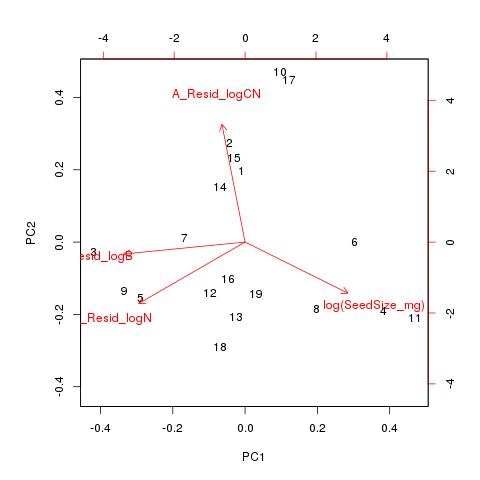

In [420]:
%%R
# PCA of annuals
phy = physeq.Nneg #start from raw object

sd = as(sample_data(phy), "data.frame")

sd = left_join(sd, SS, by = "Plant")
sd = left_join(sd, M_GDD, by = "DAP")

data = filter(sd, DAP %in% c( "53", "57", "61"))
data$Plant %>% levels %>% print

fit = prcomp(~log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + A_Resid_logB, data = data, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)
 

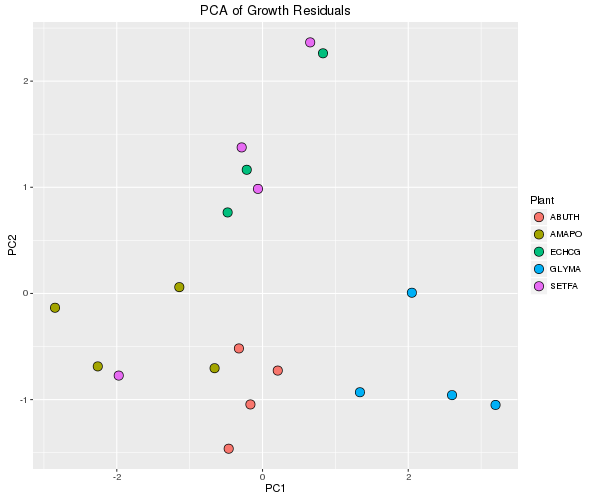

In [421]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(data[,1:57], S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(phy) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC2, fill = Plant))
p = p + geom_point(pch = 21, size = 4)
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [422]:
%%R
#measure distances on PC1
sd = sample_data(phy)
PC1dist = dist(sd[, "PC1"], method = "euclidian")
    #melt matrix
    PC1.m = melt(as.matrix(PC1dist))

    #set column names and create comparison column
     colnames(PC1.m) = c("PlotA", "PlotB", "PC1Dist")
    PC1.m$PlotComp = paste(PC1.m$PlotA, PC1.m$PlotB, sep = "-")
    PC1.m %>% head

#measure distances on PC2
PC2dist = dist(sd[,"PC2"], method = "euclidian")
    #melt matrix
    PC2.m = melt(as.matrix(PC2dist))

    #set column names and create comparison column
     colnames(PC2.m) = c("PlotA", "PlotB", "PC2Dist")
    PC2.m$PlotComp = paste(PC2.m$PlotA, PC2.m$PlotB, sep = "-")
    PC2.m %>% head

#measure distances on PC3
PC3dist = dist(sd[,"PC3"], method = "euclidian")
    #melt matrix
    PC3.m = melt(as.matrix(PC3dist))

    #set column names and create comparison column
     colnames(PC3.m) = c("PlotA", "PlotB", "PC3Dist")
    PC3.m$PlotComp = paste(PC3.m$PlotA, PC3.m$PlotB, sep = "-")
    PC3.m %>% head %>% print

#measure distances on residCN
CNdist = dist(sd[,"A_Resid_logCN"], method = "euclidian")
    #melt matrix
    CN.m = melt(as.matrix(CNdist))

    #set column names and create comparison column
     colnames(CN.m) = c("PlotA", "PlotB", "CNdist")
    CN.m$PlotComp = paste(CN.m$PlotA, CN.m$PlotB, sep = "-")
    CN.m %>% head %>% print

#measure distances on residBiomass
Bdist = dist(sd[,"A_Resid_logB"], method = "euclidian")
    #melt matrix
    B.m = melt(as.matrix(Bdist))

    #set column names and create comparison column
     colnames(B.m) = c("PlotA", "PlotB", "Bdist")
    B.m$PlotComp = paste(B.m$PlotA, B.m$PlotB, sep = "-")
    B.m %>% head %>% print

Fundist = dist(sd[,c("PC1", "PC2", "PC3")], method = "euclidian")
    Fun.m = melt(as.matrix(Fundist))

    #set column names and create comparison column
     colnames(Fun.m) = c("PlotA", "PlotB", "FunDist")
    Fun.m$PlotComp = paste(Fun.m$PlotA, PC3.m$PlotB, sep = "-")
    Fun.m %>% head %>% print
PCA.m = left_join(PC1.m, PC2.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, PC3.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, Fun.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, CN.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, B.m[,c(3,4)], by = "PlotComp")
head(PCA.m)

              PlotA             PlotB    PC3Dist
1 sample4-2.02_Nneg sample4-2.02_Nneg 0.00000000
2 sample4-4.21_Nneg sample4-2.02_Nneg 0.33812225
3 sample2-2.08_Nneg sample4-2.02_Nneg 0.61787646
4 sample3-2.03_Nneg sample4-2.02_Nneg 0.03565969
5 sample4-1.03_Nneg sample4-2.02_Nneg 0.51134978
6 sample3-3.06_Nneg sample4-2.02_Nneg 0.86741853
                             PlotComp
1 sample4-2.02_Nneg-sample4-2.02_Nneg
2 sample4-4.21_Nneg-sample4-2.02_Nneg
3 sample2-2.08_Nneg-sample4-2.02_Nneg
4 sample3-2.03_Nneg-sample4-2.02_Nneg
5 sample4-1.03_Nneg-sample4-2.02_Nneg
6 sample3-3.06_Nneg-sample4-2.02_Nneg
              PlotA             PlotB     CNdist
1 sample4-2.02_Nneg sample4-2.02_Nneg 0.00000000
2 sample4-4.21_Nneg sample4-2.02_Nneg 0.09187120
3 sample2-2.08_Nneg sample4-2.02_Nneg 0.05342428
4 sample3-2.03_Nneg sample4-2.02_Nneg 0.34226220
5 sample4-1.03_Nneg sample4-2.02_Nneg 0.17376359
6 sample3-3.06_Nneg sample4-2.02_Nneg 0.11708672
                             PlotComp
1 sample4-

In [423]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, DAY_A %in% c( "53", "57", "61") & DAY_B %in% c( "53", "57", "61"))


dim(SubDist) %>% print
SubDist$PlantA %>% unique

[1] 3741   21
[1] 171  21
[1] SETFA AMAPO GLYMA ABUTH ECHCG
Levels: ABUTH AMAPO ECHCG GLYMA SETFA


In [424]:
%%R
colnames(SubDist) %>% print
PCA.m %>% colnames %>% print

 [1] "PlotA"       "PlotB"       "w_Unif_Dist" "PlantA"      "PlantB"     
 [6] "PlantComp"   "PlotComp"    "phy_Dist"    "LibraryA"    "DAY_A"      
[11] "LibraryB"    "DAY_B"       "PC1Dist"     "PC2Dist"     "PC3Dist"    
[16] "FunDist"     "CNdist"      "Bdist"       "TimeDist"    "LibraryComp"
[21] "SameDay"    
[1] "PlotA"    "PlotB"    "PC1Dist"  "PlotComp" "PC2Dist"  "PC3Dist"  "FunDist" 
[8] "CNdist"   "Bdist"   


In [425]:
%%R
SubDist = left_join(SubDist[,c(1:12,19:21)], PCA.m[,3:9], by = "PlotComp")
tail(SubDist) %>% print


                PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
166 sample3-4.18_Nneg sample3-3.30_Nneg   0.2286788  ABUTH  ABUTH ABUTH-ABUTH
167 sample2-2.10_Nneg sample3-3.30_Nneg   0.3542649  ECHCG  ABUTH ECHCG-ABUTH
168 sample2-3.20_Nneg sample3-3.30_Nneg   0.1637463  ECHCG  ABUTH ECHCG-ABUTH
169 sample3-1.20_Nneg sample3-3.30_Nneg   0.2223193  ABUTH  ABUTH ABUTH-ABUTH
170 sample2-1.24_Nneg sample3-3.30_Nneg   0.2134040  ECHCG  ABUTH ECHCG-ABUTH
171 sample3-2.19_Nneg sample3-3.30_Nneg   0.1662544  ABUTH  ABUTH ABUTH-ABUTH
                               PlotComp phy_Dist LibraryA DAY_A LibraryB DAY_B
166 sample3-4.18_Nneg-sample3-3.30_Nneg  0.00000        2    57        2    57
167 sample2-2.10_Nneg-sample3-3.30_Nneg  0.35879        2    53        2    57
168 sample2-3.20_Nneg-sample3-3.30_Nneg  0.35879        2    53        2    57
169 sample3-1.20_Nneg-sample3-3.30_Nneg  0.00000        2    57        2    57
170 sample2-1.24_Nneg-sample3-3.30_Nneg  0.35879        2  

In [426]:
%%R
SubDist$DAY_A %>% unique

[1] 61 53 57
Levels: 53 57 61


In [427]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)


In [428]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: SubDist 
        AIC       BIC   logLik
  -572.9469 -563.5395 289.4734

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3437059 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.2442186 0.01806515 13.51877       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.9596585 -0.6918894 -0.1685355  0.7146741  2.7786870 

Residual standard error: 0.06632499 
Degrees of freedom: 171 total; 170 residual


In [433]:
%%R
fit2=  gls(w_Unif_Dist ~ SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay 
  Data: SubDist 
        AIC       BIC   logLik
  -578.4524 -565.9328 293.2262

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3583939 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.22766022 0.018828099 12.091513   0e+00
SameDay1    0.02440937 0.005966594  4.091005   1e-04

 Correlation: 
         (Intr)
SameDay1 -0.215

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7127356 -0.7151168 -0.1873108  0.6716921  2.6645671 

Residual standard error: 0.06621917 
Degrees of freedom: 171 total; 169 residual


In [435]:
%%R
fit3=  gls(w_Unif_Dist ~ SameDay + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + phy_Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -581.8775 -566.2577 295.9388

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3628187 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.21763188 0.018820106 11.563797  0.0000
SameDay1    0.01226746 0.006772043  1.811485  0.0719
phy_Dist    0.06743478 0.019637176  3.434037  0.0007

 Correlation: 
         (Intr) SamDy1
SameDay1 -0.096       
phy_Dist -0.155 -0.523

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6061678 -0.7523369 -0.1661927  0.6663387  2.6465692 

Residual standard error: 0.06508475 
Degrees of freedom: 171 total; 168 residual


In [438]:
%%R
fit4=  gls(w_Unif_Dist ~   SameDay  + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + poly(phy_Dist, 2) 
  Data: SubDist 
        AIC       BIC   logLik
  -577.5192 -558.8113 294.7596

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3631226 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)        0.23522773 0.01881830 12.499947  0.0000
SameDay1           0.01325381 0.00691106  1.917769  0.0568
poly(phy_Dist, 2)1 0.13798554 0.04058196  3.400170  0.0008
poly(phy_Dist, 2)2 0.03339920 0.04538935  0.735838  0.4629

 Correlation: 
                   (Intr) SamDy1 p(_D,2)1
SameDay1           -0.249                
poly(phy_Dist, 2)1  0.130 -0.520         
poly(phy_Dist, 2)2 -0.048  0.194 -0.037  

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6123310 -0.7762844 -0.1505322  0.6749722  2.6734668 

Residual standard error: 0.06523585 
Degrees of freedom: 171 total; 167 residual


In [443]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ SameDay +  PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + PC1Dist + PC2Dist + PC3Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -548.1808 -526.3969 281.0904

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3609218 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.21870112 0.020964027 10.432210  0.0000
SameDay1    0.02163216 0.006314605  3.425734  0.0008
PC1Dist     0.00353764 0.003172665  1.115036  0.2664
PC2Dist     0.00327086 0.003662883  0.892973  0.3732
PC3Dist     0.00067957 0.010953650  0.062040  0.9506

 Correlation: 
         (Intr) SamDy1 PC1Dst PC2Dst
SameDay1 -0.081                     
PC1Dist  -0.246 -0.206              
PC2Dist  -0.197 -0.254  0.031       
PC3Dist  -0.295 -0.039  0.048  0.050

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6839937 -0.7294376 -0.1634110  0.7385262  2.5638398 

Residual standard error: 0.06693602 
Degrees 

In [445]:
%%R
fit6=  gls(w_Unif_Dist ~SameDay + phy_Dist + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + phy_Dist + PC1Dist + PC2Dist + PC3Dist 
  Data: SubDist 
        AIC      BIC   logLik
  -550.8366 -525.989 283.4183

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3577294 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.22083065 0.020179593 10.943266  0.0000
SameDay1     0.01190287 0.006842225  1.739621  0.0838
phy_Dist     0.07862309 0.024230233  3.244834  0.0014
PC1Dist      0.00017759 0.003256979  0.054526  0.9566
PC2Dist     -0.00404259 0.004213384 -0.959465  0.3387
PC3Dist     -0.00199264 0.010684047 -0.186506  0.8523

 Correlation: 
         (Intr) SamDy1 phy_Ds PC1Dst PC2Dst
SameDay1 -0.088                            
phy_Dist  0.031 -0.438                     
PC1Dist  -0.245 -0.036 -0.318              
PC2Dist  -0.185  0.040 -0.533  0.195       
PC3Dist  -0.299 -0.002 -0.075  0.069  0.083

Standardized residuals:
       Min

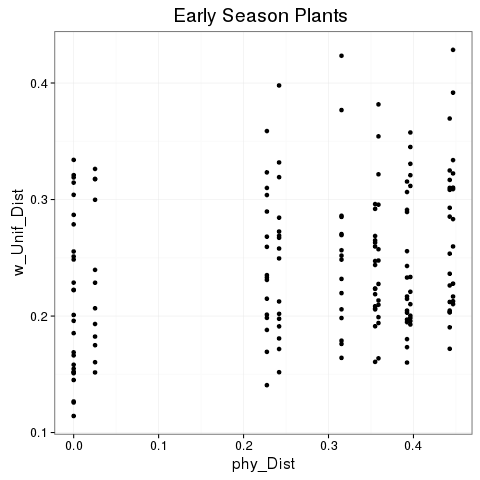

In [251]:
%%R
p1 = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p1 = p1 + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .213, se = FALSE)
p1 = p1 + theme_bw(base_size = 16)
p1 = p1 + ggtitle("Early Season Plants ")
#p = p + stat_function(fun = test)
p1

# Subset of late season plants

[1] "B73"    "ELCOR"  "ERATE"  "HELAN"  "SORBI"  "SORSUD"
Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.4973 1.1837 0.59627 0.03612
Proportion of Variance 0.5605 0.3503 0.08888 0.00033
Cumulative Proportion  0.5605 0.9108 0.99967 1.00000
                        PC1         PC2        PC3         PC4
log(SeedSize_mg) -0.5549666  0.24710822 -0.7936365 -0.03302717
A_Resid_logN     -0.4687695 -0.59539147  0.1686459 -0.63033538
A_Resid_logCN    -0.2340853  0.76240075  0.4191288 -0.43391266
A_Resid_logB     -0.6461202 -0.05649449  0.4074687  0.64288904


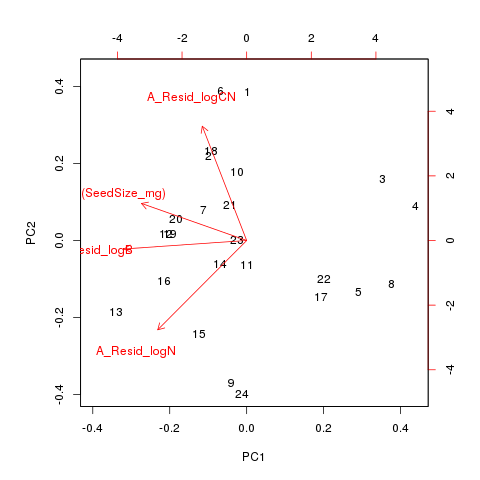

In [372]:
%%R
# PCA of annuals
sd = as(sample_data(phy), "data.frame")

# sd = left_join(sd, SS, by = "Plant")
# sd = left_join(sd, M_GDD, by = "DAP")

data = filter(sd, Plant %in% c("B73", "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN")) 
data$Plant %>% levels %>% print

fit = prcomp(~log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + A_Resid_logB, data = data, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)
 

In [371]:
%%R -w 600 -h 500
colnames(data) # find numbers to drop

 [1] "PlotA"       "PlotB"       "w_Unif_Dist" "PlantA"      "PlantB"     
 [6] "PlantComp"   "PlotComp"    "phy_Dist"    "LibraryA"    "DAY_A"      
[11] "LibraryB"    "DAY_B"       "TimeDist"    "LibraryComp" "SameDay"    
[16] "PC1Dist"     "PC2Dist"     "PC3Dist"     "FunDist"     "CNdist"     
[21] "Bdist"      


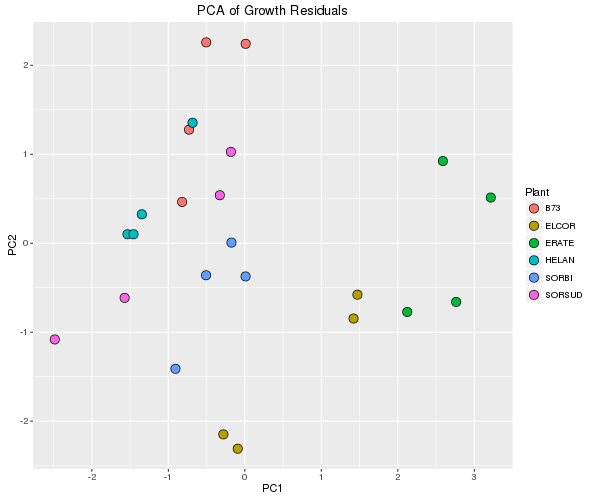

In [376]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(data[,1:57], S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(phy) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC2, fill = Plant))
p = p + geom_point(pch = 21, size = 4)
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [335]:
%%R
#measure distances on PC1
sd = sample_data(phy)
PC1dist = dist(sd[, "PC1"], method = "euclidian")
    #melt matrix
    PC1.m = melt(as.matrix(PC1dist))

    #set column names and create comparison column
     colnames(PC1.m) = c("PlotA", "PlotB", "PC1Dist")
    PC1.m$PlotComp = paste(PC1.m$PlotA, PC1.m$PlotB, sep = "-")
    PC1.m %>% head

#measure distances on PC2
PC2dist = dist(sd[,"PC2"], method = "euclidian")
    #melt matrix
    PC2.m = melt(as.matrix(PC2dist))

    #set column names and create comparison column
     colnames(PC2.m) = c("PlotA", "PlotB", "PC2Dist")
    PC2.m$PlotComp = paste(PC2.m$PlotA, PC2.m$PlotB, sep = "-")
    PC2.m %>% head

#measure distances on PC3
PC3dist = dist(sd[,"PC3"], method = "euclidian")
    #melt matrix
    PC3.m = melt(as.matrix(PC3dist))

    #set column names and create comparison column
     colnames(PC3.m) = c("PlotA", "PlotB", "PC3Dist")
    PC3.m$PlotComp = paste(PC3.m$PlotA, PC3.m$PlotB, sep = "-")
    PC3.m %>% head %>% print

#measure distances on residCN
CNdist = dist(sd[,"A_Resid_logCN"], method = "euclidian")
    #melt matrix
    CN.m = melt(as.matrix(CNdist))

    #set column names and create comparison column
     colnames(CN.m) = c("PlotA", "PlotB", "CNdist")
    CN.m$PlotComp = paste(CN.m$PlotA, CN.m$PlotB, sep = "-")
    CN.m %>% head %>% print

#measure distances on residBiomass
Bdist = dist(sd[,"A_Resid_logB"], method = "euclidian")
    #melt matrix
    B.m = melt(as.matrix(Bdist))

    #set column names and create comparison column
     colnames(B.m) = c("PlotA", "PlotB", "Bdist")
    B.m$PlotComp = paste(B.m$PlotA, B.m$PlotB, sep = "-")
    B.m %>% head %>% print

Fundist = dist(sd[,c("PC1", "PC2", "PC3")], method = "euclidian")
    Fun.m = melt(as.matrix(Fundist))

    #set column names and create comparison column
     colnames(Fun.m) = c("PlotA", "PlotB", "FunDist")
    Fun.m$PlotComp = paste(Fun.m$PlotA, PC3.m$PlotB, sep = "-")
    Fun.m %>% head %>% print
PCA.m = left_join(PC1.m, PC2.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, PC3.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, Fun.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, CN.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, B.m[,c(3,4)], by = "PlotComp")
head(PCA.m)

              PlotA             PlotB   PC3Dist
1 sample6-2.26_Nneg sample6-2.26_Nneg 0.0000000
2 sample6-3.18_Nneg sample6-2.26_Nneg 0.2178990
3 sample5-3.11_Nneg sample6-2.26_Nneg 1.6020730
4 sample5-4.06_Nneg sample6-2.26_Nneg 1.0377879
5 sample5-2.18_Nneg sample6-2.26_Nneg 1.4008179
6 sample6-4.30_Nneg sample6-2.26_Nneg 0.3642588
                             PlotComp
1 sample6-2.26_Nneg-sample6-2.26_Nneg
2 sample6-3.18_Nneg-sample6-2.26_Nneg
3 sample5-3.11_Nneg-sample6-2.26_Nneg
4 sample5-4.06_Nneg-sample6-2.26_Nneg
5 sample5-2.18_Nneg-sample6-2.26_Nneg
6 sample6-4.30_Nneg-sample6-2.26_Nneg
              PlotA             PlotB     CNdist
1 sample6-2.26_Nneg sample6-2.26_Nneg 0.00000000
2 sample6-3.18_Nneg sample6-2.26_Nneg 0.15821962
3 sample5-3.11_Nneg sample6-2.26_Nneg 0.32359357
4 sample5-4.06_Nneg sample6-2.26_Nneg 0.55719490
5 sample5-2.18_Nneg sample6-2.26_Nneg 0.75189285
6 sample6-4.30_Nneg sample6-2.26_Nneg 0.09339611
                             PlotComp
1 sample6-2.26_Nn

In [347]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, PlantA %in% c("B73",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN") & PlantB %in% c("B73", "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI",  "HELAN"))
dim(SubDist) %>% print
SubDist$PlantA %>% unique

[1] 3741   21
[1] 276  21
[1] B73    ERATE  ELCOR  SORSUD SORBI  HELAN 
Levels: B73 ELCOR ERATE HELAN SORBI SORSUD


In [351]:
%%R
colnames(SubDist)
PCA.m %>% colnames
SubDist = left_join(SubDist[,c(1:12,19:21)], PCA.m[,3:9], by = "PlotComp")
tail(SubDist) %>% print


                PlotA             PlotB w_Unif_Dist PlantA PlantB    PlantComp
271 sample7-3.12_Nneg sample8-3.03_Nneg   0.3062711  HELAN  ELCOR  HELAN-ELCOR
272 sample7-4.03_Nneg sample8-3.03_Nneg   0.3777692  HELAN  ELCOR  HELAN-ELCOR
273 sample7-1.28_Nneg sample8-3.03_Nneg   0.3428638  HELAN  ELCOR  HELAN-ELCOR
274 sample7-3.25_Nneg sample8-3.03_Nneg   0.2164129 SORSUD  ELCOR SORSUD-ELCOR
275 sample8-4.01_Nneg sample8-3.03_Nneg   0.2115333  ELCOR  ELCOR  ELCOR-ELCOR
276 sample7-4.14_Nneg sample8-3.03_Nneg   0.2893173  SORBI  ELCOR  SORBI-ELCOR
                               PlotComp phy_Dist LibraryA DAY_A LibraryB DAY_B
271 sample7-3.12_Nneg-sample8-3.03_Nneg  0.36765        2    84        2    88
272 sample7-4.03_Nneg-sample8-3.03_Nneg  0.36765        2    84        2    88
273 sample7-1.28_Nneg-sample8-3.03_Nneg  0.36765        2    84        2    88
274 sample7-3.25_Nneg-sample8-3.03_Nneg  0.04779        2    84        2    88
275 sample8-4.01_Nneg-sample8-3.03_Nneg  0.00000    

In [352]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [353]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: SubDist 
        AIC       BIC   logLik
  -665.0201 -654.1698 335.5101

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.1307399 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.2681774 0.01204274 22.26881       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.9814712 -0.6841784 -0.1141655  0.6066197  2.8341968 

Residual standard error: 0.07699199 
Degrees of freedom: 276 total; 275 residual


In [354]:
%%R
fit2=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp 
  Data: SubDist 
        AIC       BIC   logLik
  -869.3277 -847.6928 440.6638

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2552378 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.17954369 0.013293440 13.506187  0.0000
TimeDist     0.00323169 0.001433143  2.254964  0.0249
SameDay1     0.09952131 0.009430748 10.552854  0.0000
LibraryComp1 0.00345826 0.009890229  0.349664  0.7269

 Correlation: 
             (Intr) TimDst SamDy1
TimeDist     -0.078              
SameDay1     -0.183 -0.548       
LibraryComp1  0.055 -0.710  0.043

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.05951849 -0.63649379 -0.05109346  0.70998688  2.78267265 

Residual standard error: 0.05932584 
Degrees of freedom: 276 total; 272 residual


In [355]:
%%R
fit3=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -900.3415 -875.1266 457.1707

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2146269 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.16541040 0.011193372 14.777530  0.0000
TimeDist     0.00364662 0.001324804  2.752573  0.0063
SameDay1     0.08802806 0.008988500  9.793408  0.0000
LibraryComp1 0.00329250 0.009222075  0.357024  0.7214
phy_Dist     0.15981098 0.024533008  6.514121  0.0000

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist     -0.089                     
SameDay1     -0.169 -0.544              
LibraryComp1  0.057 -0.702  0.031       
phy_Dist     -0.202  0.033 -0.171  0.006

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.24750636 -0.65451700 -0.08562476  0.56041635  2.65969617 

Res

In [356]:
%%R
fit4=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) 
  Data: SubDist 
       AIC       BIC  logLik
  -906.264 -877.4766 461.132

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2156526 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.1755202 0.01127249 15.570669  0.0000
TimeDist            0.0054957 0.00142737  3.850244  0.0001
SameDay1            0.0967115 0.00924638 10.459396  0.0000
LibraryComp1       -0.0105369 0.01005832 -1.047580  0.2958
poly(phy_Dist, 2)1  0.4405850 0.06199458  7.106830  0.0000
poly(phy_Dist, 2)2  0.1781098 0.05588840  3.186883  0.0016

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1
TimeDist           -0.182                              
SameDay1           -0.282 -0.355                       
LibraryComp1        0.169 -0.755 -0.100                
poly(phy_Dist, 2)1  0.016  0.108 

In [378]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp  + PC1Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1Dist 
  Data: SubDist 
        AIC      BIC   logLik
  -901.8768 -876.662 457.9384

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2304395 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.16482928 0.011583751 14.229353  0.0000
TimeDist     -0.00152142 0.001488343 -1.022227  0.3076
SameDay1      0.08788913 0.008881266  9.896014  0.0000
LibraryComp1  0.03184962 0.010023614  3.177459  0.0017
PC1Dist       0.02165622 0.003116164  6.949642  0.0000

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist      0.016                     
SameDay1     -0.161 -0.395              
LibraryComp1 -0.025 -0.761 -0.039       
PC1Dist      -0.187 -0.467 -0.175  0.412

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.29992148 -0.61306651 -0.05617992  0.68437925  2.76111936 



In [379]:
%%R
fit6=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2)  + PC1Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) + PC1Dist 
  Data: SubDist 
       AIC       BIC  logLik
  -930.648 -898.2956 474.324

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.1889258 

Coefficients:
                       Value  Std.Error   t-value p-value
(Intercept)        0.1632054 0.01001765 16.291794  0.0000
TimeDist           0.0011996 0.00150123  0.799092  0.4249
SameDay1           0.0876705 0.00879333  9.970115  0.0000
LibraryComp1       0.0149003 0.01027685  1.449887  0.1483
poly(phy_Dist, 2)1 0.3762567 0.05832567  6.450962  0.0000
poly(phy_Dist, 2)2 0.1581972 0.05278775  2.996854  0.0030
PC1Dist            0.0184219 0.00294736  6.250308  0.0000

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1 p(_D,2)2
TimeDist           -0.073                                       
SameDay1           -0.268 -0.237                                
L

In [380]:
%%R
fit7=  gls(w_Unif_Dist ~  SameDay + poly(phy_Dist,2)  + PC1Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit7)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + poly(phy_Dist, 2) + PC1Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -941.8657 -916.6509 477.9329

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.1845845 

Coefficients:
                       Value  Std.Error   t-value p-value
(Intercept)        0.1625334 0.01006010 16.156240   0e+00
SameDay1           0.1064977 0.00704358 15.119819   0e+00
poly(phy_Dist, 2)1 0.3678224 0.05831297  6.307729   0e+00
poly(phy_Dist, 2)2 0.1749187 0.04864644  3.595714   4e-04
PC1Dist            0.0190821 0.00264285  7.220260   0e+00

 Correlation: 
                   (Intr) SamDy1 p(_D,2)1 p(_D,2)2
SameDay1           -0.342                         
poly(phy_Dist, 2)1  0.065 -0.034                  
poly(phy_Dist, 2)2 -0.272  0.412  0.139           
PC1Dist            -0.272 -0.334 -0.111    0.163  

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2

In [360]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6)

     Model df       AIC       BIC   logLik   Test   L.Ratio p-value
fit1     1  3 -665.0201 -654.1698 335.5101                         
fit2     2  6 -869.3277 -847.6928 440.6638 1 vs 2 210.30754  <.0001
fit3     3  7 -900.3415 -875.1266 457.1707 2 vs 3  33.01381  <.0001
fit4     4  8 -906.2640 -877.4766 461.1320 3 vs 4   7.92251  0.0049
fit5     5  9 -881.3531 -849.0007 449.6766 4 vs 5  22.91086  <.0001
fit6     6  9 -930.6480 -898.2956 474.3240                         


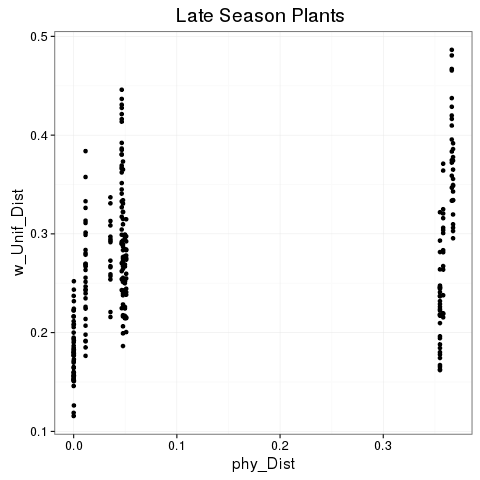

In [385]:
%%R
p2 = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p2 = p2 + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .213, se = FALSE)
p2 = p2 + theme_bw(base_size = 16)
p2 = p2 + ggtitle("Late Season Plants ")
#p = p + stat_function(fun = test)
p2

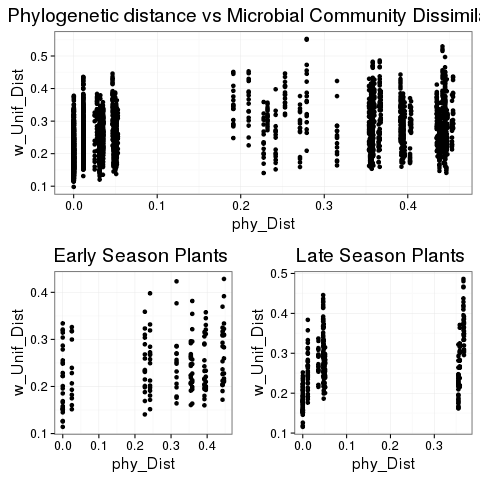

In [388]:
%%R
 grid.arrange(p,p1,p2, layout_matrix = rbind(c(1, 1), c(2,3)))

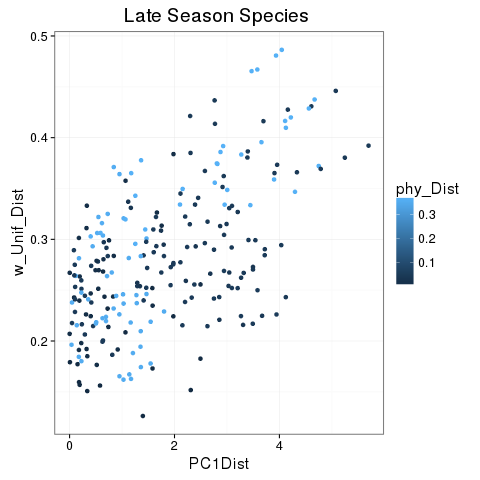

In [368]:
%%R
data = filter(SubDist, PlantA != PlantB)
p3 = ggplot(data, aes(y = w_Unif_Dist, x = PC1Dist, color = phy_Dist) )
p3 = p3 + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .213, se = FALSE)
p3 = p3 + theme_bw(base_size = 16)
p3 = p3 + ggtitle("Late Season Species ")
#p = p + stat_function(fun = test)
p3

### PCA showing just late season annuals and B73

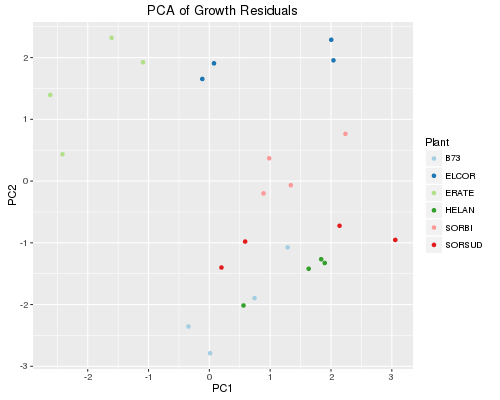

In [318]:
%%R -w 500 -h 400
data = filter(E_Fit, Plant %in% c("B73",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN") )
p = ggplot(data, aes(PC1, PC2, colour = Plant), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

# Subset of late season plants with all maize

## recreate functional distance variables on subset

In [261]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, DAY_A %in% c( "72", "79", "84", "88") & DAY_B %in% c( "72", "79", "84", "88"))

dim(SubDist) %>% print
SubDist$PlantA %>% unique


[1] 3741   21
[1] 2016   21
 [1] 75-062 MS71   B73    Oh7B   B97    H99    Il14H  ERATE  ELCOR  SORSUD
[11] Ki3    SORBI  Hp301  HELAN  Tx303  Mo18  
16 Levels: 75-062 B73 B97 ELCOR ERATE H99 HELAN Hp301 Il14H Ki3 Mo18 ... Tx303


In [262]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [263]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: SubDist 
        AIC       BIC   logLik
  -6409.249 -6392.424 3207.625

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
     Rho 
0.251618 

Coefficients:
                Value   Std.Error  t-value p-value
(Intercept) 0.2350195 0.008348303 28.15177       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.8075544 -0.7440251 -0.1621121  0.5931403  3.8053914 

Residual standard error: 0.06605584 
Degrees of freedom: 2016 total; 2015 residual


In [264]:
%%R
fit2=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp 
  Data: SubDist 
        AIC       BIC   logLik
  -6681.806 -6648.165 3346.903

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2710062 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.20345771 0.008506148 23.918900   0e+00
TimeDist     -0.00146817 0.000428982 -3.422450   6e-04
SameDay1      0.04373292 0.004098648 10.670084   0e+00
LibraryComp1  0.01768391 0.002891179  6.116504   0e+00

 Correlation: 
             (Intr) TimDst SamDy1
TimeDist      0.041              
SameDay1     -0.134 -0.782       
LibraryComp1 -0.044 -0.658  0.292

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.0889256 -0.7463494 -0.1253755  0.5947027  3.7627957 

Residual standard error: 0.06355152 
Degrees of freedom: 2016 total; 2012 residual


In [265]:
%%R
fit3=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -6778.996 -6739.751 3396.498

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2425501 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.19336502 0.007535196 25.661578  0.0000
TimeDist     -0.00091187 0.000421620 -2.162777  0.0307
SameDay1      0.03628378 0.004061779  8.932977  0.0000
LibraryComp1  0.01521089 0.002833924  5.367432  0.0000
phy_Dist      0.23521826 0.022492658 10.457557  0.0000

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist      0.028                     
SameDay1     -0.124 -0.785              
LibraryComp1 -0.037 -0.660  0.299       
phy_Dist     -0.128  0.124 -0.174 -0.082

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.5026553 -0.7282384 -0.1196183  0.6027257  3.4317787 

Residua

In [266]:
%%R
fit4=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) 
  Data: SubDist 
        AIC      BIC   logLik
  -6782.227 -6737.38 3399.114

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2345679 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.2067427 0.00726010 28.476569  0.0000
TimeDist           -0.0008803 0.00042137 -2.089043  0.0368
SameDay1            0.0356805 0.00406570  8.775987  0.0000
LibraryComp1        0.0149753 0.00283420  5.283792  0.0000
poly(phy_Dist, 2)1  1.1519411 0.11496983 10.019508  0.0000
poly(phy_Dist, 2)2 -0.1799512 0.07759734 -2.319038  0.0205

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1
TimeDist            0.051                              
SameDay1           -0.159 -0.785                       
LibraryComp1       -0.054 -0.660  0.300                
poly(phy_Dist, 2)1  0.035  0.11

In [267]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp  + PC2Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)



Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC2Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -6670.959 -6631.714 3342.479

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2701235 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.20125779 0.008585233 23.442322  0.0000
TimeDist     -0.00140737 0.000430484 -3.269268  0.0011
SameDay1      0.04258019 0.004159509 10.236830  0.0000
LibraryComp1  0.01738842 0.002896085  6.004112  0.0000
PC2Dist       0.00211841 0.001319284  1.605730  0.1085

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist      0.026                     
SameDay1     -0.104 -0.783              
LibraryComp1 -0.033 -0.660  0.298       
PC2Dist      -0.160  0.088 -0.172 -0.063

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.0700325 -0.7397505 -0.1186156  0.5945767  3.7603069 

Residual

In [268]:
%%R
fit6=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2)  + PC2Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) + PC2Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -6768.807 -6718.359 3393.404

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2345896 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.2065111 0.00739707 27.917941  0.0000
TimeDist           -0.0008755 0.00042248 -2.072178  0.0384
SameDay1            0.0355831 0.00410961  8.658508  0.0000
LibraryComp1        0.0149521 0.00283838  5.267844  0.0000
poly(phy_Dist, 2)1  1.1499523 0.11563366  9.944789  0.0000
poly(phy_Dist, 2)2 -0.1785691 0.07806171 -2.287538  0.0223
PC2Dist             0.0002149 0.00130386  0.164801  0.8691

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1 p(_D,2)2
TimeDist            0.037                                       
SameDay1           -0.127 -0.784                      

# Sandbox

In [18]:
%%R
# # PCA of annuals
# sd = as(sample_data(phy), "data.frame")
# sd$Plant %>% levels %>% print
# sd = left_join(sd, SS, by = "Plant")
# sd = left_join(sd, M_GDD, by = "DAP")

#  fit = prcomp(~log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + A_Resid_logB, data = sd, 
#                  na.action = na.exclude, center = TRUE, scale = TRUE)

# summary(fit) %>% print
# fit$rotation %>% print
# biplot(fit)

NULL


In [19]:
%%R -w 600 -h 500
# S = predict(fit)[,1:3]
# E_Fit = cbind(sd, S)
# row.names(E_Fit) = E_Fit$X.sample
# sample_data(phy) = E_Fit


# p = ggplot(E_Fit, aes(PC1, PC3, colour = Plant, 
#                        size = A_Resid_logN), pch = 21)
# p = p + geom_point()
# #p = p + scale_colour_brewer(palette="Paired")
# p = p + ggtitle("PCA of Growth Residuals")
# p

NULL


In [20]:
%%R
# p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
#                        size = A_Resid_logN), pch = 21)
# p = p + geom_point()
# #p = p + scale_colour_brewer(palette="Paired")
# p = p + ggtitle("PCA of Growth Residuals")
# p

NULL


In [ ]:
%%R
# PC1dist = dist(sd[, "PC1"], method = "euclidian")
#     #melt matrix
#     PC1.m = melt(as.matrix(PC1dist))

#     #set column names and create comparison column
#      colnames(PC1.m) = c("PlotA", "PlotB", "PC1Dist")
#     PC1.m$PlotComp = paste(PC1.m$PlotA, PC1.m$PlotB, sep = "-")
#     PC1.m %>% head

# #measure distances on PC2
# PC2dist = dist(sd[,"PC2"], method = "euclidian")
#     #melt matrix
#     PC2.m = melt(as.matrix(PC2dist))

#     #set column names and create comparison column
#      colnames(PC2.m) = c("PlotA", "PlotB", "PC2Dist")
#     PC2.m$PlotComp = paste(PC2.m$PlotA, PC2.m$PlotB, sep = "-")
#     PC2.m %>% head

# #measure distances on PC3
# PC3dist = dist(sd[,"PC3"], method = "euclidian")
#     #melt matrix
#     PC3.m = melt(as.matrix(PC3dist))

#     #set column names and create comparison column
#      colnames(PC3.m) = c("PlotA", "PlotB", "PC3Dist")
#     PC3.m$PlotComp = paste(PC3.m$PlotA, PC3.m$PlotB, sep = "-")
#     PC3.m %>% head %>% print

### Not used, but if date/combo is random effect:

In [ ]:
%%R
Dist$DateCombo = ifelse(as.numeric(as.character(Dist$DAY_A)) < as.numeric(as.character(Dist$DAY_B)),
                                                                    paste(Dist$DAY_A, Dist$DAY_B, sep = "-"), 
                                                                   paste(Dist$DAY_B, Dist$DAY_A, sep = "-"))
Dist$DateCombo %>% unique


In [ ]:
%%R


fit10 <- lme(w_Unif_Dist ~ 1, random =~ 1|DateCombo, correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
summary(fit10) %>% print


In [ ]:
%%R
fit11 <- lme(w_Unif_Dist ~ phy_Dist, random =~ 1|DateCombo, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)

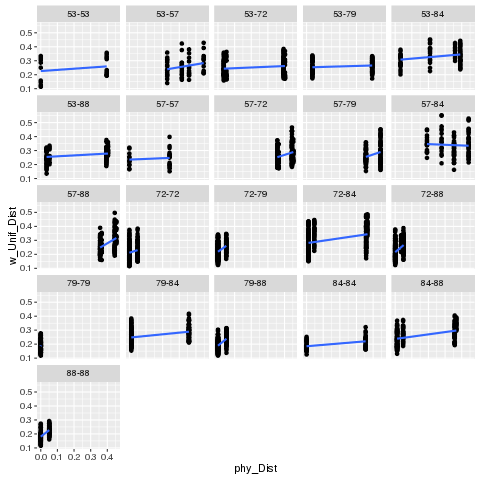

In [123]:
%%R

p = ggplot(Dist, aes(x = phy_Dist, y = w_Unif_Dist))
           p = p + geom_point()
        p = p + stat_smooth(method = "lm", se = FALSE)
           p = p + facet_wrap(~DateCombo)
           p